# 04. Baseline Model 1: development roadmap and baseline logit model


# Contents

1. Introduction to modelling roadmap
2. Preparation for baseline modelling
3. Reviewing distribution of numeric features pre-scaling
4. Dummy encoding after split
5. Checking for collineraity and multicollinearity
6. Scaling features
7. Building on logit model with backward selection
8. Base model measures and coefficients
9. Interpreting findings
10. Model performance
11. Conclusion and next steps


# 1. Introduction to modelling roadmap

## (a) Experimenting with 4 different models, of varying complexity:

In this notebook, we introduce the development roadmap for our modelling process - starting with a baseline logit model. 

* The roadmap is designed to systematically evaluate the performance of different machine learning models, ranging from the basic logistic regression model to more advanced techniques, such as decision trees, random forests, and neural networks.

* The goal is to understand how more complex models compare with the baseline logistic regression, particularly in terms of accuracy, interpretability, and computational efficiency. Starting with logistic regression provides a simple, interpretable model that can serve as a baseline for comparison with other, more advanced techniques.

The image below provides an overview of the models that will be covered in our development roadmap:

![Model Roadmap](../visualisations/model_roadmap.png)


## (b) Baseline model 1: Logistic Regression implementation:

In this notebook, we will construct our base logistic regression model for predicting our target variable of `high job satisfaction`. We will construct and implement the logistic regression model, discuss the feature selection process using the Variance Inflation Factor (VIF) and backward selection, and evaluate the model's performance. This will form the foundation for more advanced models, which will be explored in subsequent notebooks.



First importing any necessary libraries before we proceed:

In [1]:
# Importing essential libraries
import pandas as pd          
import numpy as np         
import matplotlib.pyplot as plt  
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import os
import statsmodels.api as sm

Loading our necessary dataframe:

In [2]:
base_model_df = pd.read_csv("../data_for_EDA/final_eda.csv")

# 2. Preparation for baseline modelling

When we train a model using the entire dataset, there's a risk that the model will learn the specific patterns and noise in that data, leading to overfitting. Overfitting means the model performs exceptionally well on the data it has seen (the training data) but fails to generalize to new, unseen data.
By splitting the data, we use the training set to develop and fine-tune the model, while the test set serves as an unseen validation to check how well the model generalizes.

## (a) Train-test split, and stratification

We'll start by splitting the data into training and test sets before applying dummy encoding. We will use stratify to ensure that the proportion of our target variable is consistent in both the training and test sets. This prevents class imbalance in either the training or test sets, which could lead to biased results. The stratify parameter in train_test_split() ensures that the binary target distribution is maintained across the split.

In [3]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = base_model_df.drop(columns=['high_jobsat'])  # Independent variables
y = base_model_df['high_jobsat']  # Target variable

# Split the data into training and test sets, using stratify to preserve the proportion of 'high_jobsat'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Verify the shapes
print(f'Training set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

# Check the distribution of high_jobsat in both train and test sets
print(f'Training set high_jobsat distribution:\n{y_train.value_counts(normalize=True)}')
print(f'Test set high_jobsat distribution:\n{y_test.value_counts(normalize=True)}')


Training set shape: (206726, 27)
Test set shape: (88597, 27)
Training set high_jobsat distribution:
high_jobsat
1    0.897299
0    0.102701
Name: proportion, dtype: float64
Test set high_jobsat distribution:
high_jobsat
1    0.897299
0    0.102701
Name: proportion, dtype: float64


As expected, `stratify` has ensured the same proportion in each of the train-test datasets.

# 3. Reviewing distribution of numeric features pre-scaling

Let's remind ourselves of the distribution of our feature set. We have a lot of features, so we can hone in on continuous and ordinal variables as a start:

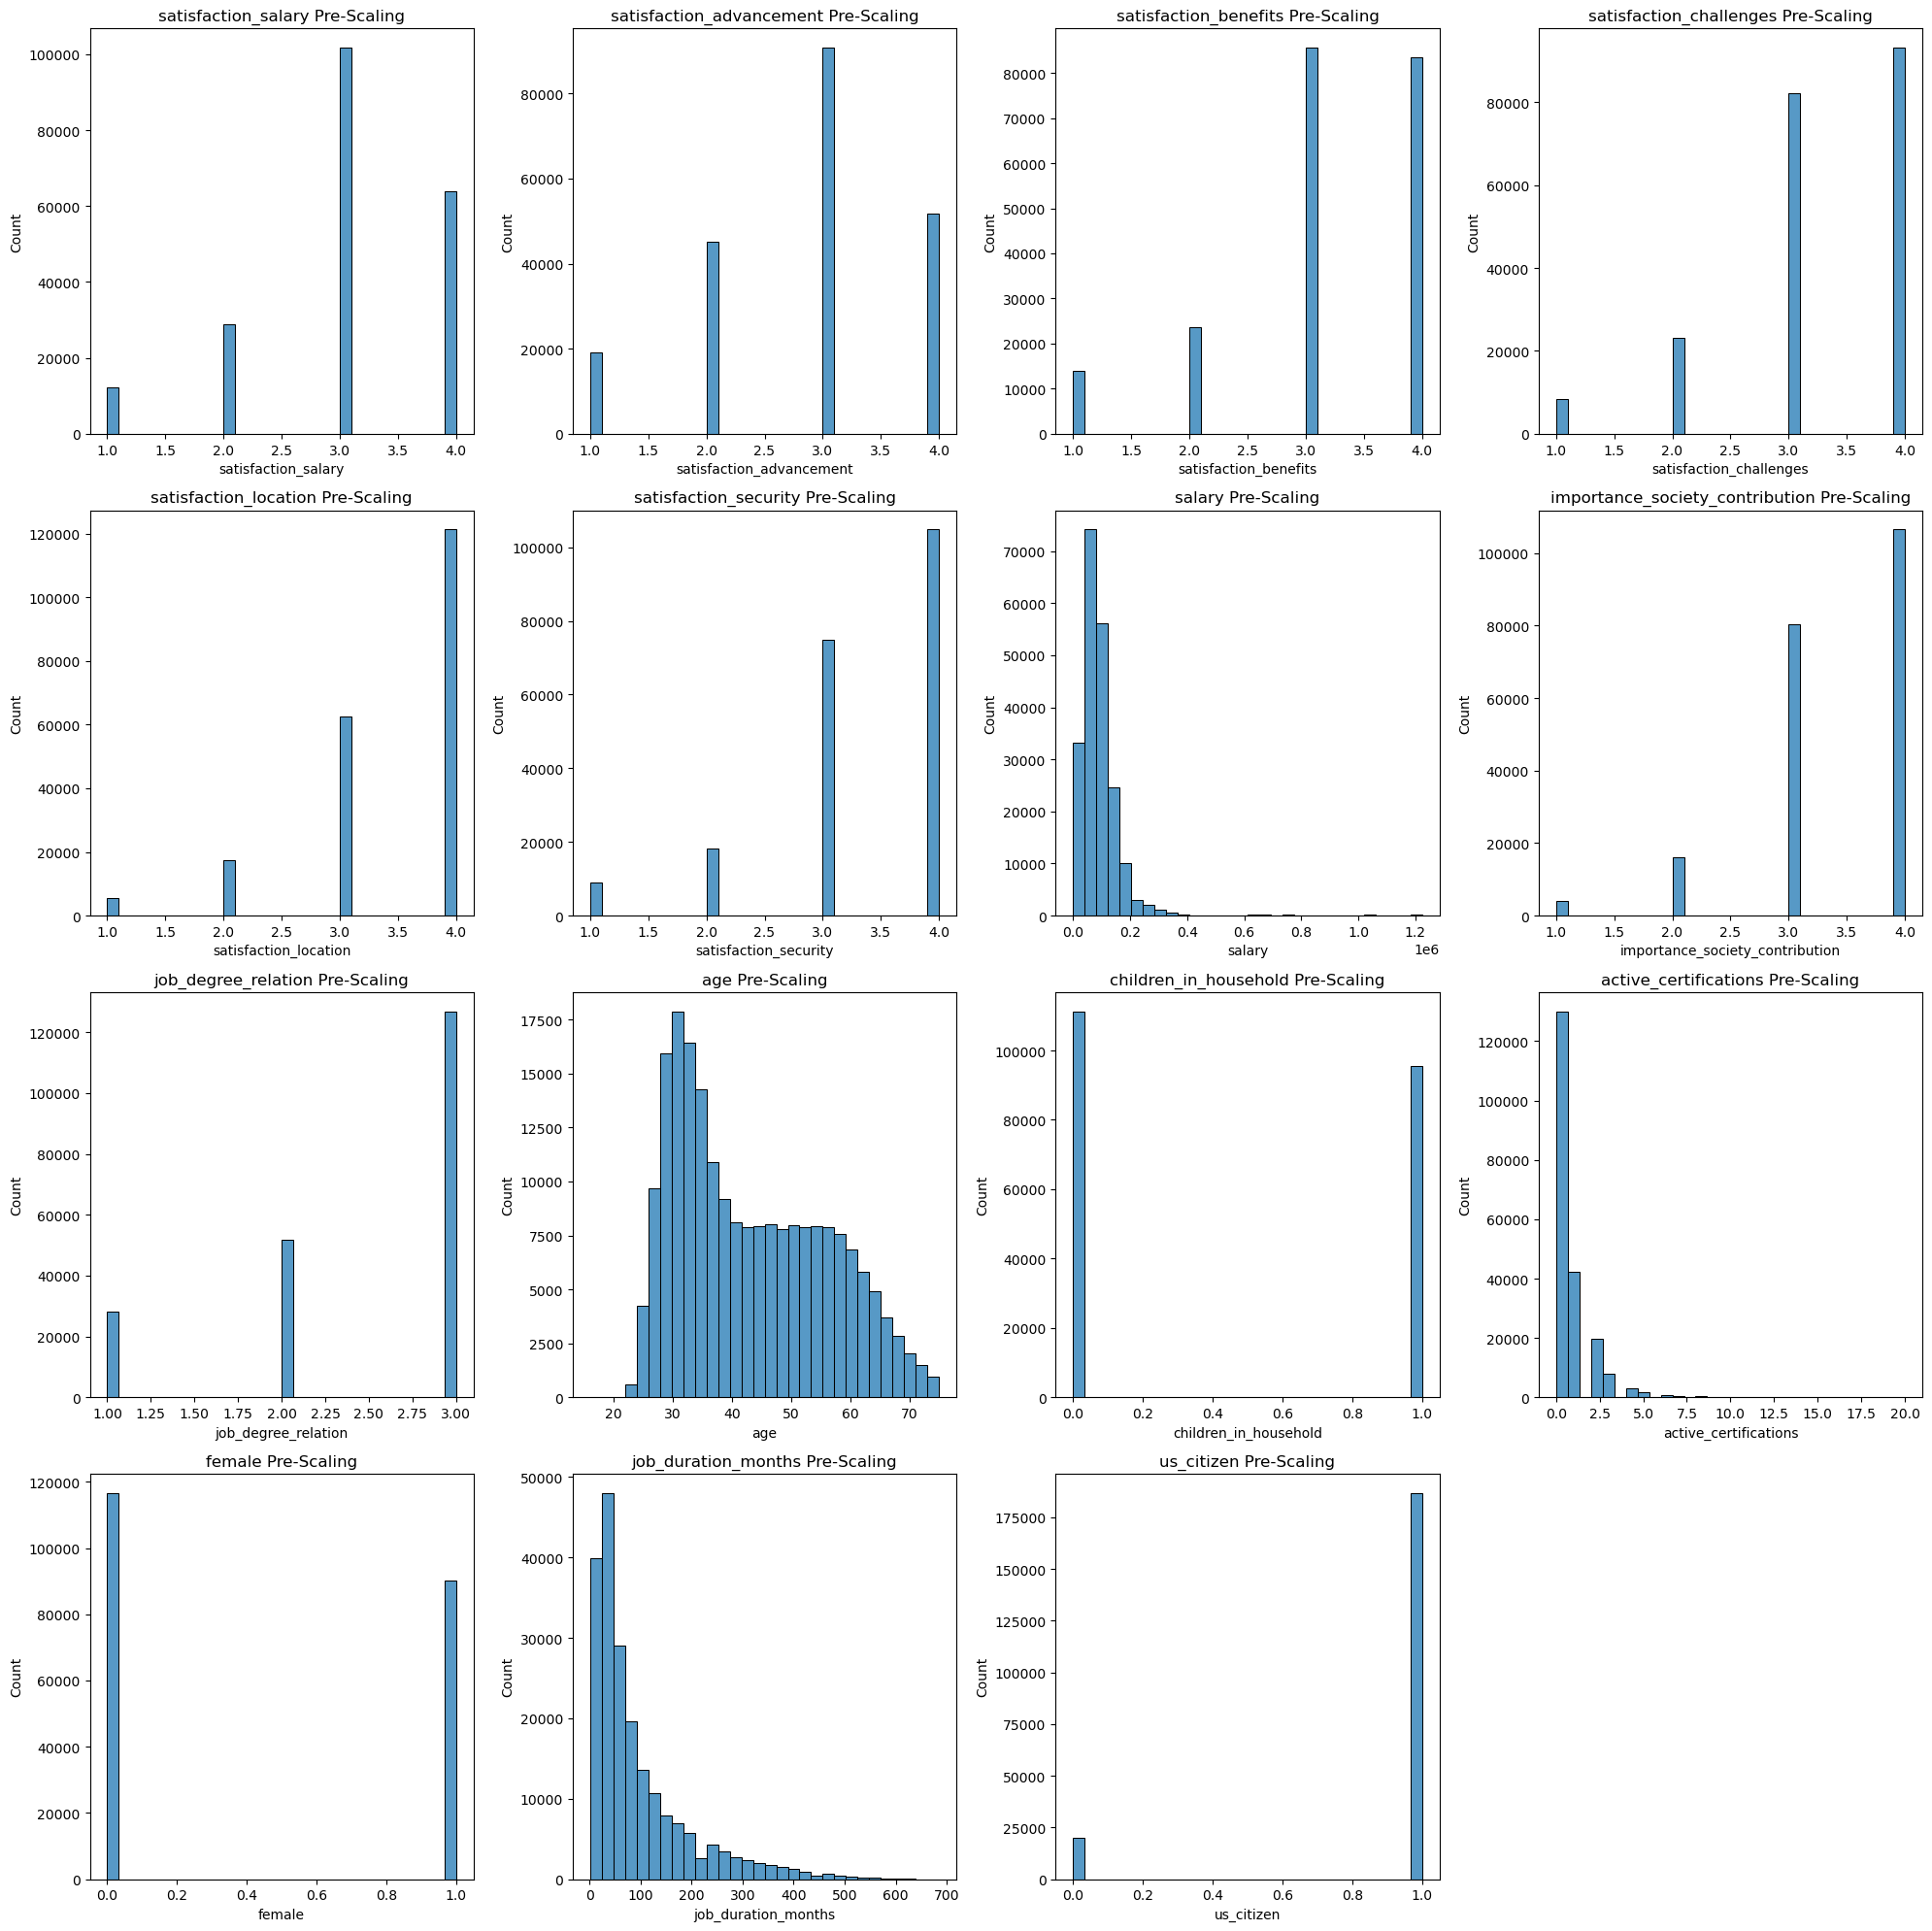

In [4]:
# Automatically select numeric types (int64, float64) for continuous and ordinal variables
X_train_cont_ordinal = X_train.select_dtypes(include=['int64', 'float64'])

# Get the number of features to determine grid size for subplots
num_features = X_train_cont_ordinal.shape[1]

# Determine the number of rows and columns for subplots based on the number of features
num_cols = 4  
num_rows = int(np.ceil(num_features / num_cols))  # Calculate the necessary number of rows

# Plotting all continuous and ordinal features pre-scaling
plt.figure(figsize=(num_cols * 5, num_rows * 5))  # Adjust figure size based on number of plots
for i, column in enumerate(X_train_cont_ordinal.columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(X_train_cont_ordinal[column], kde=False, bins=30)  # Using histplot to show distribution
    plt.title(f'{column} Pre-Scaling')

plt.tight_layout()
plt.show()

We can already see that a lot of this data is heavily right-skewed. We will still want to keep this shape of the distribution, but consider what scaling we can apply to make this comparable.

We will come back to this a little later on, before constructing our logsitic regression model.

# 4. Dummy Encoding after split

We apply dummy encoding to both the training and test sets after splitting. This prevents data leakage, which would occur if the test data influenced the training process. The categorical variables are converted to binary flags, and we ensure consistency by aligning columns across both datasets to guarantee the same structure.

In [5]:
# Apply one-hot encoding separately to object columns in the training and test sets
X_train_dummies = pd.get_dummies(
    X_train, 
    columns=X_train.select_dtypes(include=['object']).columns,  # Only dummy encode object (categorical) columns
    drop_first=True,  # Drop the first category
    prefix_sep='_',  # Use underscore as the separator between column and category
    dtype=int  # Ensure binary encoding with integers (1s and 0s)
)

X_test_dummies = pd.get_dummies(
    X_test, 
    columns=X_test.select_dtypes(include=['object']).columns,  # Only dummy encode object (categorical) columns
    drop_first=True,  # Drop the first category
    prefix_sep='_',  # Use underscore as the separator between column and category
    dtype=int  # Ensure binary encoding with integers (1s and 0s)
)

# Align columns between training and test sets to ensure they have the same structure
X_train_dummies, X_test_dummies = X_train_dummies.align(X_test_dummies, join='left', axis=1, fill_value=0)

# Verify the results
print(X_train_dummies.dtypes)  # Ensure all dummies are of int type
print(X_train_dummies.head())  # View first few rows to verify


satisfaction_salary         int64
satisfaction_advancement    int64
satisfaction_benefits       int64
satisfaction_challenges     int64
satisfaction_location       int64
                            ...  
ethnicity_Other             int64
ethnicity_White             int64
survey_date_2017-02-01      int64
survey_date_2019-02-01      int64
survey_date_2021-02-01      int64
Length: 329, dtype: object
        satisfaction_salary  satisfaction_advancement  satisfaction_benefits  \
129590                    4                         4                      4   
141270                    3                         2                      4   
280500                    4                         4                      4   
221544                    4                         3                      4   
36168                     3                         3                      3   

        satisfaction_challenges  satisfaction_location  satisfaction_security  \
129590                        4      

It looks like all our variables have been encoded as expected. And we've made sure that the structure of the train dataset aligns with the test dataset.

# 5. Checking for collinearity and multicollinearity

Since we have high dimensionality in this dataset, let's first inspect any correlations between our features which are greater than 0.95 to address any issues of perfect collinearity.

We can inspect the variation of these features to understand which ones we might consider dropping:

In [6]:
# Compute the absolute correlation matrix
corr_matrix = X_train_dummies.corr().abs()

# Select the upper triangle of the correlation matrix to avoid duplicate correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = []
high_corr_pairs = []  # To store highly correlated feature pairs for visualization
for column in upper.columns:
    highly_corr_features = upper.index[upper[column] > 0.95].tolist()  # Find highly correlated features for the current column
    
    # Compare the variation (standard deviation) of the highly correlated features
    for feature in highly_corr_features:
        std_col = X_train_dummies[column].std()  # Standard deviation of current column
        std_feature = X_train_dummies[feature].std()  # Standard deviation of correlated feature
        
        # Drop the feature with less variation (lower standard deviation)
        if std_col < std_feature:
            to_drop.append(column)  # If current column has less variation, mark it for drop
        else:
            to_drop.append(feature)  # Otherwise, mark the correlated feature for drop

        # Store the highly correlated pair and their correlation for visualization
        high_corr_pairs.append((column, feature, corr_matrix.loc[column, feature]))

# Drop duplicates from the to_drop list
to_drop = list(set(to_drop))

# Optional: Display the pairs of highly correlated features and their correlation values
print("\nHighly correlated feature pairs (correlation > 0.95):")
for col, feat, corr_value in high_corr_pairs:
    print(f"{col} and {feat}: {corr_value}")



Highly correlated feature pairs (correlation > 0.95):
citizenship_status_Y and us_citizen: 1.0
respondent_region_East South Central and employer_region_East South Central: 0.9989183368472302
respondent_region_Middle Atlantic and employer_region_Middle Atlantic: 0.9994211847057276
respondent_region_Mountain and employer_region_Mountain: 0.999433977981412
respondent_region_New England and employer_region_New England: 0.99933124022112
respondent_region_Pacific and employer_region_Pacific: 0.9997176428836096
respondent_region_South Atlantic and employer_region_South Atlantic: 0.999691325759642
respondent_region_U.S. Territory and employer_region_U.S. Territory: 0.9987958200328231
respondent_region_West North Central and employer_region_West North Central: 0.9991890890678039
respondent_region_West South Central and employer_region_West South Central: 0.9995475567586751
survey_date_2017-02-01 and survey_year_2017-01-01: 1.0
survey_date_2019-02-01 and survey_year_2019-01-01: 1.0
survey_date_

In [7]:
to_drop

['employer_region_New England',
 'employer_region_Pacific',
 'respondent_region_West North Central',
 'respondent_region_East South Central',
 'survey_year_2021-01-01',
 'survey_year_2019-01-01',
 'respondent_region_Mountain',
 'survey_year_2017-01-01',
 'employer_region_South Atlantic',
 'employer_region_West South Central',
 'us_citizen',
 'respondent_region_U.S. Territory',
 'respondent_region_Middle Atlantic']

Based on the above we can drop the following variables:

1. Redundant Variables:

`citizenship_status_Y`: This is dropped because it's a redundant version of us_citizen (they are perfectly correlated).

`survey_year_ `variables: All variables starting with survey_year_ are dropped because they’re redundant with survey_date_ variables, as indicated by perfect correlations (1.0).

2. Regional Variables (Selected Based on Multicollinearity and Variance):

* Respondent Regions` (e.g., respondent_region_U.S. Territory, respondent_region_Mountain, etc.) are dropped because they are highly correlated with employer region variables and have lower variance.

* Employer Regions (e.g., employer_region_West South Central, employer_region_South Atlantic, etc.) are dropped for the same reason, keeping the most varying and informative features.

This combination of criteria ensures that your model remains interpretable, and it handles multicollinearity by simplifying the feature set. This step will make the logistic regression coefficients easier to explain, as each remaining variable will carry unique information without redundanc

Let's go ahead and drop these variables, ensuring to align this with the test dataset as well:

In [8]:
# List of variables to drop based on multicollinearity and variance considerations
variables_to_drop = [
    'citizenship_status_Y',
    'respondent_region_U.S. Territory',
    'respondent_region_Mountain',
    'respondent_region_Middle Atlantic',
    'respondent_region_East South Central',
    'employer_region_West South Central',
    'employer_region_South Atlantic',
    'employer_region_New England',
    'respondent_region_West North Central',
    'employer_region_Pacific'
]

# Dropping all survey_year_ variables (any column starting with 'survey_year_')
survey_year_cols = [col for col in X_train_dummies.columns if col.startswith('survey_year_')]

# Combine both lists of variables to drop
all_variables_to_drop = variables_to_drop + survey_year_cols

# Drop these variables from the training and test datasets
X_train_dummies = X_train_dummies.drop(columns=all_variables_to_drop)
X_test_dummies = X_test_dummies.drop(columns=all_variables_to_drop)

# Print the remaining columns to verify
print(f"Remaining features after dropping: {X_train_dummies.columns}")


Remaining features after dropping: Index(['satisfaction_salary', 'satisfaction_advancement',
       'satisfaction_benefits', 'satisfaction_challenges',
       'satisfaction_location', 'satisfaction_security', 'salary',
       'importance_society_contribution', 'job_degree_relation', 'age',
       ...
       'respondent_region_Other', 'respondent_region_Pacific',
       'respondent_region_South Atlantic',
       'respondent_region_West South Central', 'ethnicity_Black',
       'ethnicity_Other', 'ethnicity_White', 'survey_date_2017-02-01',
       'survey_date_2019-02-01', 'survey_date_2021-02-01'],
      dtype='object', length=316)


Let's review the correlation coefficients again, this time for correlations > 0.5. We'll plot this as a table of the relevant variable pairs given the high dimensionality nature of our dataset:

In [9]:
# Recalculate the correlation matrix
corr_matrix = X_train_dummies.corr().abs()

# Find all pairs of features with correlation > 0.5
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.5:
            high_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation Coefficient': corr_matrix.iloc[i, j]
            })

# Convert the list of high correlation pairs to a DataFrame
high_corr_df = pd.DataFrame(high_corr_pairs)

# Sort by correlation coefficient for better readability
high_corr_df = high_corr_df.sort_values(by='Correlation Coefficient', ascending=False)

# Display the DataFrame
high_corr_df.head(20)  # Show the first 20 rows of the highly correlated pairs

,Feature 1,Feature 2,Correlation Coefficient
16,employer_region_Other,respondent_region_Other,0.793978
9,recent_degree_field_Law/Prelaw/Legal Studies,"occupation_name_Lawyers, judges",0.752841
15,marital_status_Married,marital_status_Never married,0.712752
8,recent_degree_field_Law/Prelaw/Legal Studies,recent_degree_type_Professional,0.668656
5,recent_degree_field_Civil engineering,"occupation_name_Civil, including architectural...",0.639990
12,"recent_degree_field_Medicine (dentistry,optome...",occupation_name_Diagnosing/treating practition...,0.623439
3,recent_degree_field_Atmospheric sciences and m...,occupation_name_Atmospheric and space scientists,0.619556
10,recent_degree_field_Mechanical engineering,occupation_name_Mechanical engineers,0.595153
13,recent_degree_field_Nursing (4 years or longer...,"occupation_name_RNs, pharmacists, dieticians, ...",0.559857
14,recent_degree_type_Professional,"occupation_name_Lawyers, judges",0.552964


First, we can see that the `respondent_region_Other` and `employer_region_Other` variable has a high correlation of around 0.8:

In [10]:
# Check the tvalue counts for 'recent_degree_field_Law/PreLaw/Legal Studies'
region_other = X_train_dummies['respondent_region_Other'].value_counts()

# Check the value counts for 'occupation_name_Lawyers, judges'
emp_other = X_train_dummies['employer_region_Other'].value_counts()

# Print the value counts for comparison
print("Value counts for 'respondentother region':\n", region_other)
print("\nValue counts for 'employer: other region':\n", emp_other)

Value counts for 'respondentother region':
 respondent_region_Other
0    206542
1       184
Name: count, dtype: int64

Value counts for 'employer: other region':
 employer_region_Other
0    206606
1       120
Name: count, dtype: int64


Since both columns have a similarly low variation, and keeping both may not provide much additional information, we can consider dropping the one with fewer occurrences of "1." In this case, that would be:

Dropping employer_region_Other (120 occurrences of 1 vs. 188 in respondent_region_Other).



In [11]:
# Drop 'employer_region_Other' from both train and test sets
X_train_dummies = X_train_dummies.drop(columns=['employer_region_Other'])
X_test_dummies = X_test_dummies.drop(columns=['employer_region_Other'])

Next, we can compare the value counts for the recent degree field vs occupation name linked to Law, which have correlations of 0.75

In [12]:
# Check the value counts for 'recent_degree_field_Law/Prelaw/Legal Studies'
recent_degree_law = X_train_dummies['recent_degree_field_Law/Prelaw/Legal Studies'].value_counts()

# Check the value counts for 'occupation_name_Lawyers, judges'
occupation_law = X_train_dummies['occupation_name_Lawyers, judges'].value_counts()

# Print the value counts for comparison
print("Value counts for 'recent_degree_field_Law/Prelaw/Legal Studies':\n", recent_degree_law)
print("\nValue counts for 'occupation_name_Lawyers, judges':\n", occupation_law)


Value counts for 'recent_degree_field_Law/Prelaw/Legal Studies':
 recent_degree_field_Law/Prelaw/Legal Studies
0    201893
1      4833
Name: count, dtype: int64

Value counts for 'occupation_name_Lawyers, judges':
 occupation_name_Lawyers, judges
0    203174
1      3552
Name: count, dtype: int64


The 'occupation_name_Lawyers, judges' has fewer instances in the positive category (1), meaning it might have slightly more variance.

As such we can consider dropping the recent_degree_field variable instead.

In [13]:
# Drop 'employer_region_Other' from both train and test sets
X_train_dummies = X_train_dummies.drop(columns=['recent_degree_field_Law/Prelaw/Legal Studies'])
X_test_dummies = X_test_dummies.drop(columns=['recent_degree_field_Law/Prelaw/Legal Studies'])

Let's review the highly correlated variables again:

In [14]:
# Recalculate the correlation matrix
corr_matrix = X_train_dummies.corr().abs()

# Find all pairs of features with correlation > 0.5
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.5:
            high_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation Coefficient': corr_matrix.iloc[i, j]
            })

# Convert the list of high correlation pairs to a DataFrame
high_corr_df = pd.DataFrame(high_corr_pairs)

# Sort by correlation coefficient for better readability
high_corr_df = high_corr_df.sort_values(by='Correlation Coefficient', ascending=False)

# Display the DataFrame
high_corr_df.head(20)  # Show the first 20 rows of the highly correlated pairs

,Feature 1,Feature 2,Correlation Coefficient
13,marital_status_Married,marital_status_Never married,0.712752
5,recent_degree_field_Civil engineering,"occupation_name_Civil, including architectural...",0.639990
10,"recent_degree_field_Medicine (dentistry,optome...",occupation_name_Diagnosing/treating practition...,0.623439
3,recent_degree_field_Atmospheric sciences and m...,occupation_name_Atmospheric and space scientists,0.619556
8,recent_degree_field_Mechanical engineering,occupation_name_Mechanical engineers,0.595153
11,recent_degree_field_Nursing (4 years or longer...,"occupation_name_RNs, pharmacists, dieticians, ...",0.559857
12,recent_degree_type_Professional,"occupation_name_Lawyers, judges",0.552964
4,recent_degree_field_Chemical engineering,occupation_name_Chemical engineers,0.546099
6,"recent_degree_field_Electrical, electronics an...",occupation_name_Electrical and electronics eng...,0.542274
0,satisfaction_advancement,satisfaction_challenges,0.531392


Let's hone in on the top 6 highest correlation coefficients - given the remainder is closer to our 0.5 threshold, we will keep these features in for now:

In [15]:
high_corr_df.head(6)

,Feature 1,Feature 2,Correlation Coefficient
13,marital_status_Married,marital_status_Never married,0.712752
5,recent_degree_field_Civil engineering,"occupation_name_Civil, including architectural...",0.639990
10,"recent_degree_field_Medicine (dentistry,optome...",occupation_name_Diagnosing/treating practition...,0.623439
3,recent_degree_field_Atmospheric sciences and m...,occupation_name_Atmospheric and space scientists,0.619556
8,recent_degree_field_Mechanical engineering,occupation_name_Mechanical engineers,0.595153
11,recent_degree_field_Nursing (4 years or longer...,"occupation_name_RNs, pharmacists, dieticians, ...",0.559857


In [16]:
# Display the top 6 highly correlated pairs
top_6_pairs = high_corr_df.head(6)

# Calculate variances for the features in each pair
variances = {}
for feature in pd.unique(top_6_pairs[['Feature 1', 'Feature 2']].values.ravel()):
    variances[feature] = X_train_dummies[feature].var()

# Compare variances in each pair and decide which feature to drop
features_to_drop = []
for idx, row in top_6_pairs.iterrows():
    feature_1 = row['Feature 1']
    feature_2 = row['Feature 2']
    
    # Compare variance and drop the one with lower variance
    if variances[feature_1] < variances[feature_2]:
        features_to_drop.append(feature_1)
    else:
        features_to_drop.append(feature_2)

# Display the features to drop
print(f"Features to drop based on lower variance: {features_to_drop}")


Features to drop based on lower variance: ['marital_status_Never married', 'occupation_name_Civil, including architectural/sanitary engineers', 'occupation_name_Diagnosing/treating practitioners (dent,optom,physicians,psych,pod,surgn,vet)', 'occupation_name_Atmospheric and space scientists', 'occupation_name_Mechanical engineers', 'recent_degree_field_Nursing (4 years or longer program)']


Let's go ahead and drop these features:

In [17]:
# Drop the features with lower variance (identified from top 6 pairs)
X_train_dummies = X_train_dummies.drop(columns=features_to_drop)
X_test_dummies = X_test_dummies.drop(columns=features_to_drop)

In [18]:
# Print the current number of features in training and test sets
print(f"Number of features in the training set after dropping highly correlated features: {X_train_dummies.shape[1]}")
print(f"Number of features in the test set after dropping highly correlated features: {X_test_dummies.shape[1]}")

Number of features in the training set after dropping highly correlated features: 308
Number of features in the test set after dropping highly correlated features: 308


## Checking for multicollinearity using Variance Inflation Factor

The Variance Inflation Factor (VIF) is a measure used to detect multicollinearity among the independent variables (features) in a regression model. Multicollinearity occurs when two or more features are highly correlated, which can lead to instability in the estimated coefficients and make the model less interpretable

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Add constant to the dataset (training data only)
X_const = sm.add_constant(X_train_dummies)

# Exclude the constant from VIF calculation
X_no_const = X_const.drop(columns=['const'])  # Drop the constant (intercept) column

# Calculate VIF for each feature
vif_values = []
num_features = X_no_const.shape[1]

for i in range(num_features):
    vif_value = variance_inflation_factor(X_no_const.values, i)
    vif_values.append(vif_value)
    
    # Print progress after each calculation
    print(f"Processed {i+1}/{num_features} features. Current VIF: {vif_value}")

# Create a pandas Series for VIF values
vif = pd.Series(vif_values, index=X_no_const.columns)

# Filter features with high VIF (e.g., VIF > 5)
high_vif_features = vif[vif > 5].index
print(f"Features with VIF > 5: {high_vif_features}")

# # Drop features with VIF > 5 from the training and test datasets
# X_train_dummies = X_train_dummies.drop(columns=high_vif_features)
# X_test_dummies = X_test_dummies.drop(columns=high_vif_features)

# # Display the remaining features after VIF check
# print(f"Remaining features after VIF check in training set: {X_train_dummies.columns}")


Processed 1/308 features. Current VIF: 23.931264463859616
Processed 2/308 features. Current VIF: 19.23836082901611
Processed 3/308 features. Current VIF: 22.666543553150824
Processed 4/308 features. Current VIF: 27.96736875179747
Processed 5/308 features. Current VIF: 25.20606398000704
Processed 6/308 features. Current VIF: 25.930886004804098
Processed 7/308 features. Current VIF: 3.1270007701691713
Processed 8/308 features. Current VIF: 27.353690833268548
Processed 9/308 features. Current VIF: 19.535071105533422
Processed 10/308 features. Current VIF: 20.312067394413404
Processed 11/308 features. Current VIF: 2.362755420313869
Processed 12/308 features. Current VIF: 1.5403129942099458
Processed 13/308 features. Current VIF: 2.390591896822088
Processed 14/308 features. Current VIF: 2.7254433800777904
Processed 15/308 features. Current VIF: 13.065331237600947
Processed 16/308 features. Current VIF: 1.300197406824547
Processed 17/308 features. Current VIF: 1.4614071703905764
Processed 18

TO understand this better, let's sort this into descending order.

In [20]:
vif.sort_values(ascending=False).head(50)

respondent_region_Pacific                                                                              29.170762
satisfaction_challenges                                                                                27.967369
importance_society_contribution                                                                        27.353691
respondent_region_South Atlantic                                                                       26.387326
satisfaction_security                                                                                  25.930886
satisfaction_location                                                                                  25.206064
satisfaction_salary                                                                                    23.931264
satisfaction_benefits                                                                                  22.666544
employer_region_East North Central                                                              

We can see the a number of variables have high Variance Inflation Factor values linked to respondent region and ethnicity. White ethnicity has a VIF greater than 5 as well - however, given the prominence of this feature from our EDA and as this is closer to our threshold, we will keep this in for now.

In fact, we can see that some features based on domain knowledge are important for consideration - highlighting that whilst VIF can address multicollinearity, it doesn't account for a feature's importance in predicitng the target variable. Given this, we will apply a more lenient threshold of VIF values >20.

We can investigate these further as we perform backwards selection for our model.

In [21]:
# Adjusting VIF threshold to 20 and dropping features with VIF > 20
high_vif_features = vif[vif > 20].index
print(f"Features with VIF > 20: {high_vif_features}")


Features with VIF > 20: Index(['satisfaction_salary', 'satisfaction_benefits',
       'satisfaction_challenges', 'satisfaction_location',
       'satisfaction_security', 'importance_society_contribution', 'age',
       'employer_region_East North Central', 'employer_region_Middle Atlantic',
       'respondent_region_Pacific', 'respondent_region_South Atlantic'],
      dtype='object')


Let's know go ahead and drop selected highi VIF features form our dataset:

In [22]:
# Drop features with high VIF (>25) from train and test sets
X_train_final = X_train_dummies.drop(columns=high_vif_features)
X_test_final = X_test_dummies.drop(columns=high_vif_features)


# 6. Scaling features

As we saw with our features earlier, scaling can help by ensuring that features with different ranges don't disproportionately influence the model. Scaling ensures consistency across all features.

Before proceeding to perform backwards selection for our statsmodel logistic regression, we will go ahead and scale our data:

In [23]:
X_train_final.head()

,satisfaction_advancement,salary,job_degree_relation,children_in_household,active_certifications,female,job_duration_months,us_citizen,recent_degree_field_Actuarial science,"recent_degree_field_Aerospace, aeronautical and astronautical engineering",...,employer_region_West North Central,respondent_region_New England,respondent_region_Other,respondent_region_West South Central,ethnicity_Black,ethnicity_Other,ethnicity_White,survey_date_2017-02-01,survey_date_2019-02-01,survey_date_2021-02-01
129590,4,94000.0,2,0,1.0,0,37,1,0,0,...,0,0,0,0,1,0,0,1,0,0
141270,2,161000.0,2,1,0.0,1,13,1,0,0,...,0,0,0,0,0,0,0,0,1,0
280500,4,240000.0,1,0,0.0,1,49,1,0,0,...,0,0,0,0,0,0,0,0,0,1
221544,3,79000.0,3,1,1.0,0,25,1,0,0,...,0,0,0,0,0,0,1,0,0,1
36168,3,350000.0,3,1,1.0,0,229,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [24]:
from sklearn.preprocessing import StandardScaler

# Scale the training and test sets after VIF analysis
scaler = StandardScaler()

# Scale training data
X_train_final_scaled = scaler.fit_transform(X_train_final)

#Convert back to df
X_train_final_scaled = pd.DataFrame(X_train_final_scaled, columns=X_train_final.columns)


# Scale test data (for evaluation later)
X_test_final_scaled = scaler.transform(X_test_final)

#Convert back to df

X_test_final_scaled = pd.DataFrame(X_test_final_scaled, columns=X_test_final.columns)


Let's now plot the newly scaled features, honing on on the first 10 to undertsand the difference made:

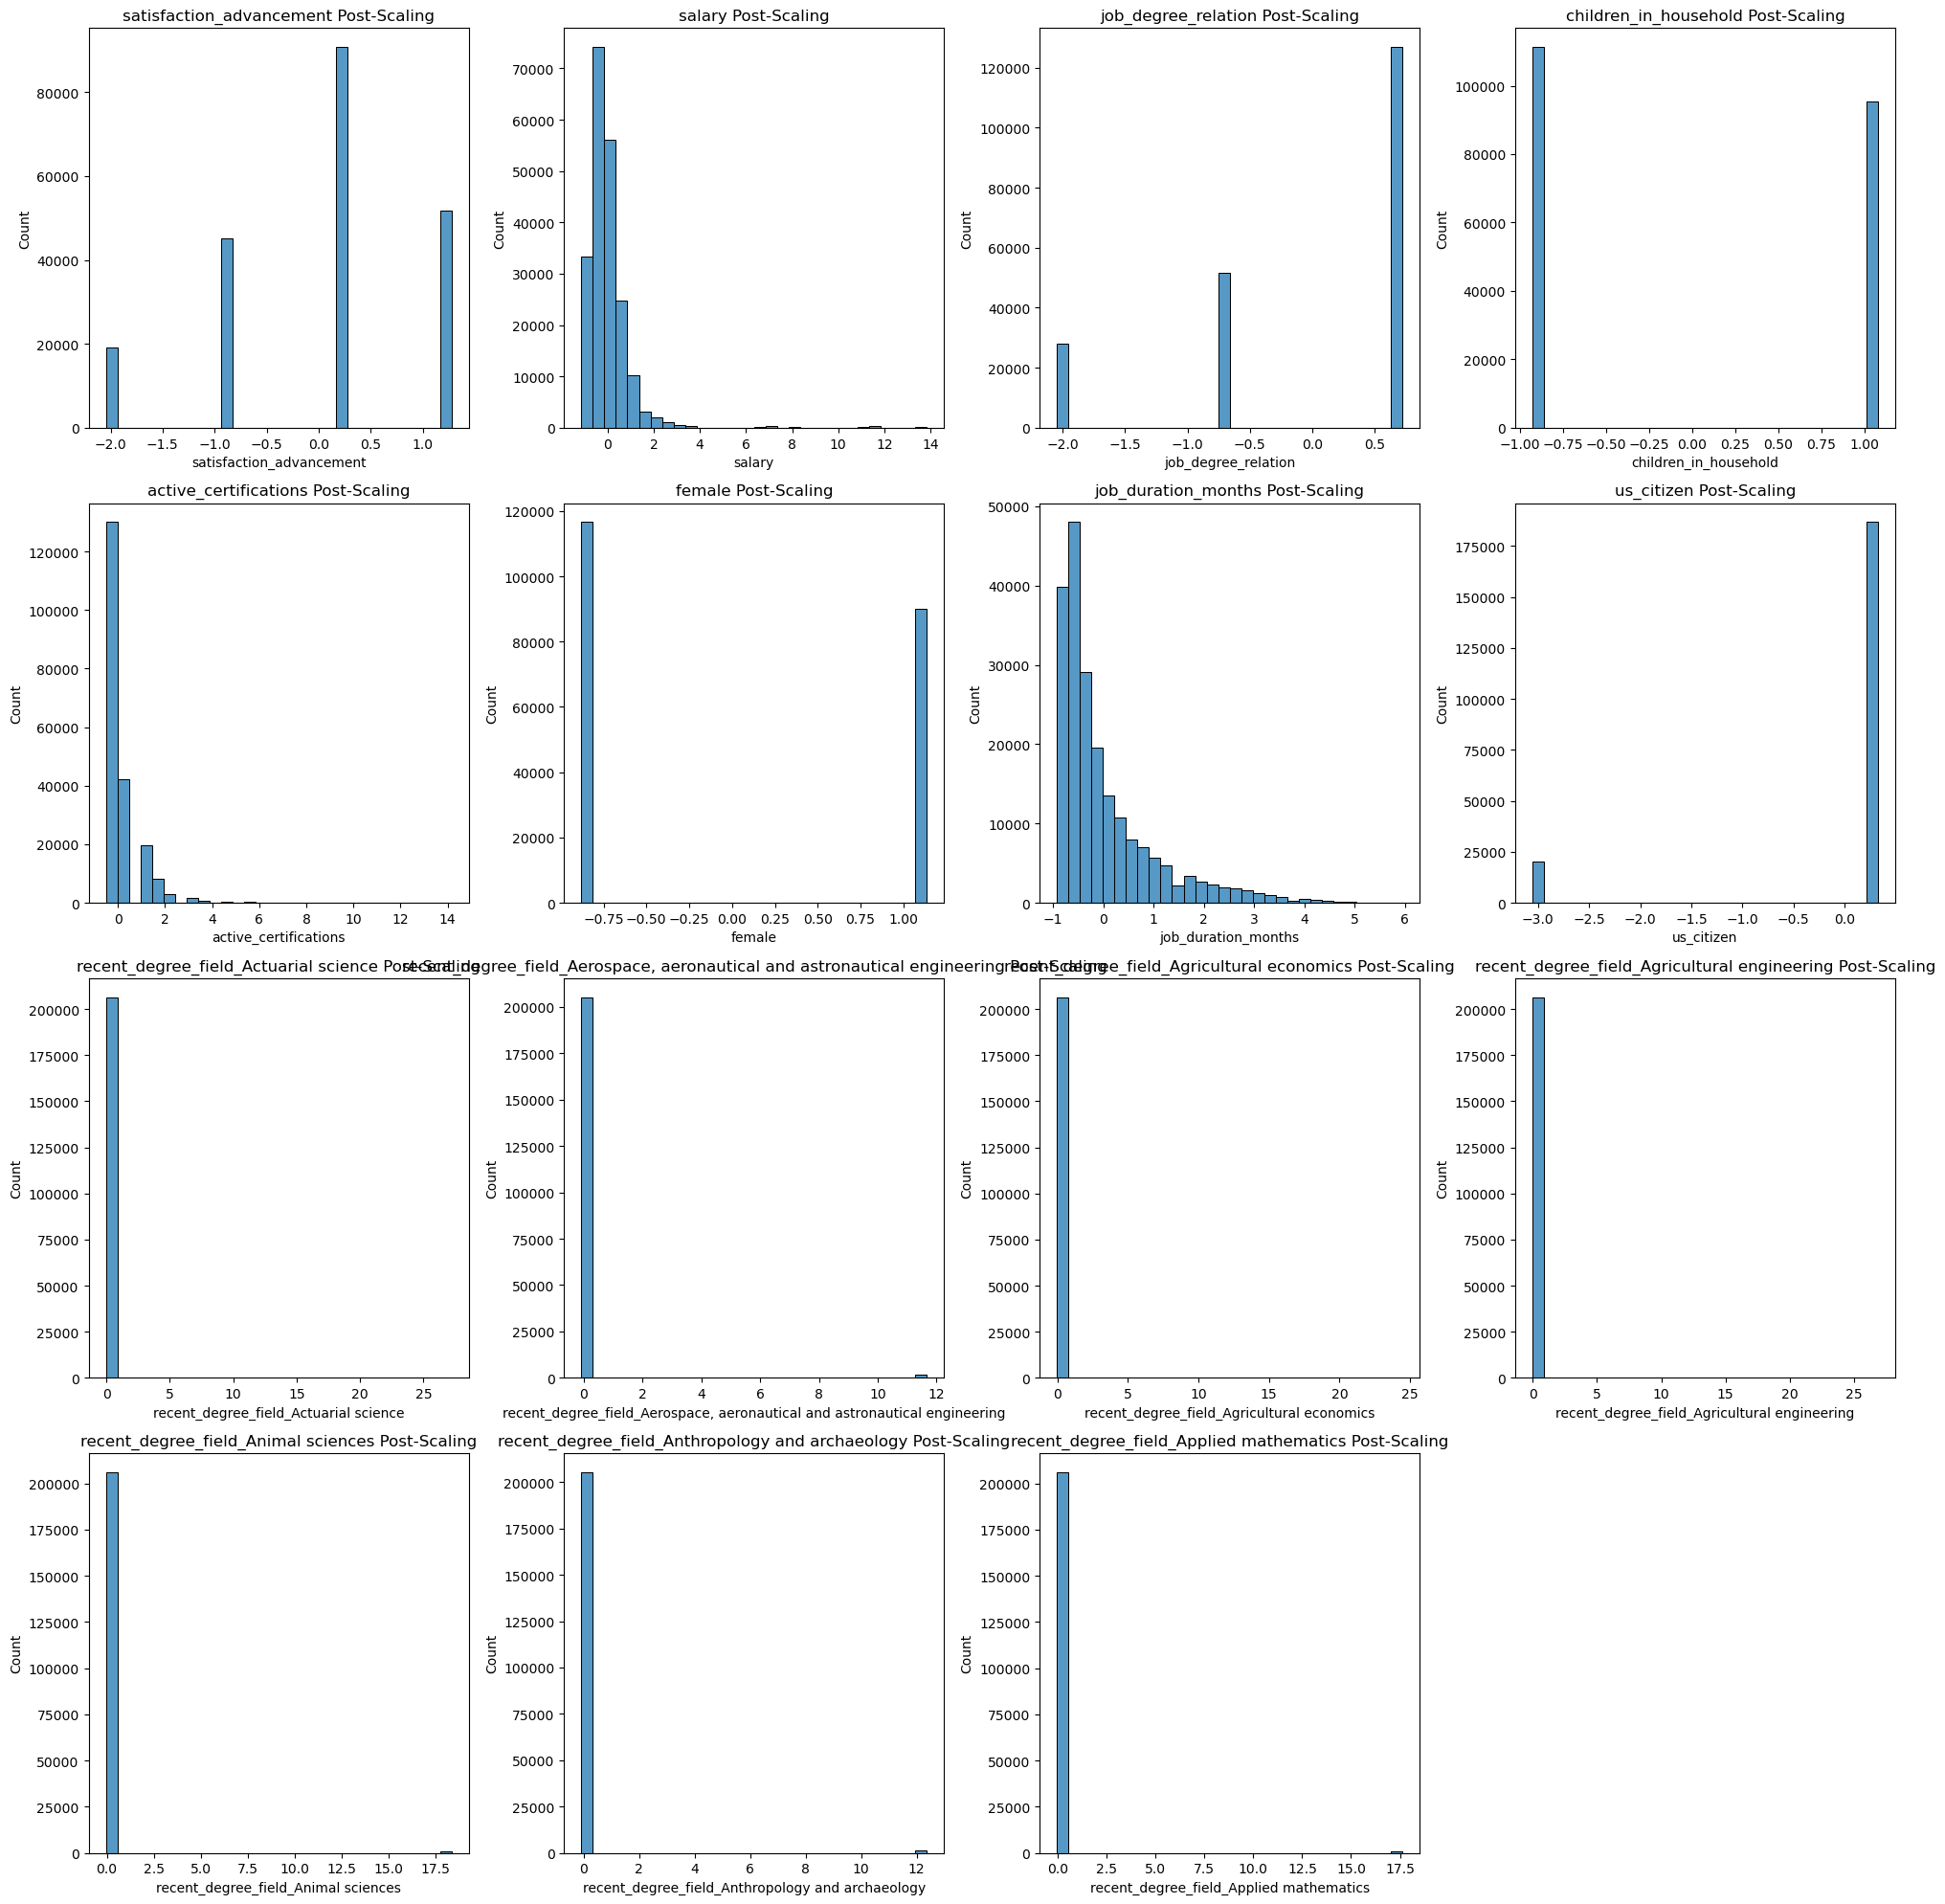

In [25]:
# Select only the first 15 columns from the scaled DataFrame for plotting
X_train_final_scaled_first_15 = X_train_final_scaled.iloc[:, :15]  # First 15 columns

# Get the number of features to determine grid size for subplots (limit to 15)
num_features = X_train_final_scaled_first_15.shape[1]

# Determine the number of rows and columns for subplots
num_cols = 4  # Adjust for wider plots if needed
num_rows = int(np.ceil(num_features / num_cols))  # Calculate the necessary number of rows

# Plotting the first 15 continuous and ordinal features post-scaling
plt.figure(figsize=(num_cols * 5, num_rows * 5))  # Adjust figure size based on number of plots

for i, column in enumerate(X_train_final_scaled_first_15.columns[:num_features], 1):  # Using scaled features
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(X_train_final_scaled_first_15[column], kde=False, bins=30)  # Plotting scaled features
    plt.title(f'{column} Post-Scaling')

plt.tight_layout()
plt.show()



What Happened to Salary:

* Pre-scaling: The salary variable had a skewed distribution with a long right tail, representing some higher salary values.

* Post-scaling: salary values that were originally far from the mean (i.e., high salaries) are brought within a standardized range (closer to 1), while those closer to the mean are scaled to smaller values (closer to 0 or -1).

Result: The large values that previously existed are now adjusted and made relative to the overall distribution, which is why you see the transformation

However, as expected the shape of the distributions are still skewed.

This transformation helps my model treat all features on an equal footing, particularly for features like salary, which can have a much larger range than others.

# 7. Building on logit model with backwards selection

We will follow a process of backwards feature selection, starting with our base logit model using statsmodel. Following this, we iterate on this by inspecting features with the highest p-values and dropping these in batches:

## First adding the constants

In [26]:
# Add constant to the scaled training data
X_train_final_const = sm.add_constant(X_train_final_scaled)

# Add constant to the scaled test data
X_test_final_const = sm.add_constant(X_test_final_scaled)

## Instantiating and fitting our base logit model

In [27]:
# Ensure the indices of X_train_final_const and y_train are aligned

# Reset indices for both X_train_final_const and y_train
X_train_final_const = X_train_final_const.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Instantiate the base model using X_const 
base_logit = sm.Logit(y_train, X_train_final_const)

# Fit the model
fitted_base_logit = base_logit.fit(maxiter=1000)

# Summary to inspect p-values
print(fitted_base_logit.summary())


         Current function value: 0.239452
         Iterations: 1000


/opt/anaconda3/envs/nivi_capstone/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            high_jobsat   No. Observations:               206726
Model:                          Logit   Df Residuals:                   206428
Method:                           MLE   Df Model:                          297
Date:                Thu, 19 Sep 2024   Pseudo R-squ.:                  0.2765
Time:                        12:31:27   Log-Likelihood:                -49501.
converged:                      False   LL-Null:                       -68422.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                                                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

# 8. Base model measures and coefficients:

* Pseudo R-squared (0.2739): This value indicates how well the model explains the variability in the dependent variable (in this case, high_jobsat, i.e., high job satisfaction). 
* A value of 0.2739 suggests that around 27.4% of the variability in job satisfaction is explained by the model. While lower than what you'd see in linear regression, it's reasonable for logistic regression.

Interpretation of Key Coefficients:

1. Since we standardized the features, a one standard deviation increase in satisfaction with advancement leads to a 1.4006 increase in the log-odds of being highly satisfied with the job. 

2. A one standard deviation increase in standardized salary leads to a 0.1508 increase in the log-odds of being highly satisfied with the job. 

3. If the job is related to the person’s degree, the log-odds of being highly satisfied with the job increase by 0.2165. 

4. A one standard deviation increase in children in the household leads to a 0.0379 increase in the log-odds of being highly satisfied with the job. This effect is statistically significant (p-value = 0.000), but the impact is small.

5. Being female increases the log-odds of being highly satisfied with the job by 0.0272. This is a small effect but is statistically significant (p-value = 0.004).

6. For every one standard deviation increase in job duration, the log-odds of being highly satisfied with the job increase by 0.2758. In terms of odds, exp(0.2758) ≈ 1.3173, meaning the odds of high job satisfaction are 31.7% higher for each additional standard deviation of job duration.

7. Being a U.S. citizen is associated with a 0.0155 increase in the log-odds of high job satisfaction, although this effect is not statistically significant (p-value = 0.089).

We will explore these coefficients in more detail including odds ratios as we iterate the model further.




## Let's determine our base model accuracy on the training set:

In [28]:
# Calculate soft predictions (probabilities) on the training set
y_train_proba = fitted_base_logit.predict(X_train_final_const)

# Convert soft predictions to hard predictions (0/1)
y_train_pred = np.where(y_train_proba >= 0.5, 1, 0)

# Ensure indices of y_train_pred and y_train match
y_train = y_train.reset_index(drop=True)

# Calculate the number of correct predictions on the training set
num_correct_train = (y_train_pred == y_train).sum()

# Calculate percentage accuracy on the training set
pct_accuracy_train = num_correct_train / X_train_final_const.shape[0]

# Print percentage accuracy with three decimal points for the training set
print(f'The BASE MODEL accuracy on the training set is {pct_accuracy_train * 100:.3f}%')


The BASE MODEL accuracy on the training set is 90.621%


The is relatively good, although we will want to explore classification errors in greater depth as we iterate the model.

The test set accuracy is not included at this stage to avoid data leakage.

Let's now inspect the p-values to identify the least statistically significant features, which will aid us in our backwards selection. We have a high-dimension dataset, so we can try to inspect features in groups of 5 to 10 - wary of dropping too many variables at once, but at the same time acknowledging that a number of feature may not have strong predictive power:

In [29]:
# Extract p-values from the fitted base model
p_values = fitted_base_logit.pvalues.sort_values(ascending=False)

# Identify the 5 features with the highest p-values
high_p_value_features = p_values.head(5).index
print(f"Features to drop in iteration 1: {list(high_p_value_features)}")


Features to drop in iteration 1: ['recent_degree_field_History of science', 'recent_degree_field_Nuclear engineering', 'recent_degree_field_Marketing research', 'respondent_region_Other', 'occupation_name_Sales - Commodities except retail (industrial/med/dental machine,equip,supplies)']


We then drop these features, as we move onto our next iteration of the model:

In [30]:
print(high_p_value_features)

Index(['recent_degree_field_History of science',
       'recent_degree_field_Nuclear engineering',
       'recent_degree_field_Marketing research', 'respondent_region_Other',
       'occupation_name_Sales - Commodities except retail (industrial/med/dental machine,equip,supplies)'],
      dtype='object')


In [31]:
# Drop these features from the training set (X_train_final_const)
X_train_iter1_const = X_train_final_const.drop(columns=high_p_value_features)

## Iteration (1)

In [32]:
# Re-add the constant to X_train_iter1_const (after dropping high p-value features)
X_train_iter1_const = sm.add_constant(X_train_iter1_const)

In [33]:
# Refit the model using the updated training set (X_train_iter1_const)
logit_iter1 = sm.Logit(y_train, X_train_iter1_const)
fitted_logit_iter1 = logit_iter1.fit(maxiter=1000)

# Print summary
print(fitted_logit_iter1.summary())

Optimization terminated successfully.
         Current function value: 0.239457
         Iterations 88
                           Logit Regression Results                           
Dep. Variable:            high_jobsat   No. Observations:               206726
Model:                          Logit   Df Residuals:                   206433
Method:                           MLE   Df Model:                          292
Date:                Thu, 19 Sep 2024   Pseudo R-squ.:                  0.2765
Time:                        12:32:13   Log-Likelihood:                -49502.
converged:                       True   LL-Null:                       -68422.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                                                                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

In [34]:
# Extract p-values from the fitted model (first iteration)
p_values_iter1 = fitted_logit_iter1.pvalues.sort_values(ascending=False)

# Identify the 5 features with the highest p-values
high_p_value_features_iter1 = p_values_iter1.head(5).index
print(f"Features to drop in iteration 1: {list(high_p_value_features_iter1)}")


Features to drop in iteration 1: ['employer_region_Oceania', 'employer_region_United Kingdom', 'const', 'occupation_name_Precision/production occupations (metal/wood work,butchers,baker,assembler,tailor)', 'recent_degree_field_Oceanography']


Dropping these variables:

In [35]:
# Drop these features from the training set (X_train_iter1_const)
X_train_iter2_const = X_train_iter1_const.drop(columns=high_p_value_features_iter1)

## Iteration (2)

In [36]:
# # Reset index for both X_train_iter2_const and y_train to ensure alignment
# X_train_iter2_const = X_train_iter2_const.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)

# Re-add the constant for X_train_iter2_const
X_train_iter2_const = sm.add_constant(X_train_iter2_const)

# Refit the model using the updated training set (X_train_iter2_const)
logit_iter2 = sm.Logit(y_train, X_train_iter2_const)
fitted_logit_iter2 = logit_iter2.fit(maxiter=1000)

# Print summary to inspect p-values after iteration 2
print(fitted_logit_iter2.summary())

Optimization terminated successfully.
         Current function value: 0.239464
         Iterations 26
                           Logit Regression Results                           
Dep. Variable:            high_jobsat   No. Observations:               206726
Model:                          Logit   Df Residuals:                   206437
Method:                           MLE   Df Model:                          288
Date:                Thu, 19 Sep 2024   Pseudo R-squ.:                  0.2765
Time:                        12:32:28   Log-Likelihood:                -49503.
converged:                       True   LL-Null:                       -68422.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                                                                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

So far, we aren't seeing a drop in the pseudo-squared nor any improvements, suggesting this may be plateauing.

We will conduct one more drop of the highest 

In [37]:
# Extract p-values from the fitted model after iteration 2
p_values_iter2 = fitted_logit_iter2.pvalues.sort_values(ascending=False)

# Identify the 10 features with the highest p-values for iteration 2
high_p_value_features_iter2 = p_values_iter2.head(5).index
print(f"Features to drop in iteration 2: {list(high_p_value_features_iter2)}")

Features to drop in iteration 2: ['employer_region_Central America', 'const', 'recent_degree_field_Operations research', 'recent_degree_field_Geography', 'recent_degree_field_Cell and molecular biology']


In [38]:
# Drop these features from the training set for iteration 3
X_train_iter3_const = X_train_iter2_const.drop(columns=high_p_value_features_iter2)

## Iteration (3)

In [39]:
# # Reset index for both X_train_iter3_const and y_train to ensure alignment
# X_train_iter3_const = X_train_iter3_const.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)

# Re-add the constant for X_train_iter3_const
X_train_iter3_const = sm.add_constant(X_train_iter3_const)

# Refit the model using the updated training set (X_train_iter3_const)
logit_iter3 = sm.Logit(y_train, X_train_iter3_const)
fitted_logit_iter3 = logit_iter3.fit(maxiter=1000)

# Print summary to inspect p-values after iteration 3
print(fitted_logit_iter3.summary())

Optimization terminated successfully.
         Current function value: 0.239465
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            high_jobsat   No. Observations:               206726
Model:                          Logit   Df Residuals:                   206441
Method:                           MLE   Df Model:                          284
Date:                Thu, 19 Sep 2024   Pseudo R-squ.:                  0.2765
Time:                        12:32:34   Log-Likelihood:                -49504.
converged:                       True   LL-Null:                       -68422.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                                                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

Evaluate model accuracy at this point:

In [40]:
# Calculate soft predictions (probabilities) on the training set before inspecting p-values
y_train_proba_iter3 = fitted_logit_iter3.predict(X_train_iter3_const)

# Convert soft predictions to hard predictions (0/1)
y_train_pred_iter3 = np.where(y_train_proba_iter3 >= 0.5, 1, 0)

# Calculate training set accuracy
pct_accuracy_train_iter3 = (y_train_pred_iter3 == y_train).sum() / X_train_iter3_const.shape[0]
print(f'The training set accuracy after Iteration 3 is {pct_accuracy_train_iter3 * 100:.3f}%')


The training set accuracy after Iteration 3 is 90.621%


In [41]:
# Now, extract p-values from the fitted model after iteration 3
p_values_iter3 = fitted_logit_iter3.pvalues.sort_values(ascending=False)

# Identify the 10 features with the highest p-values for iteration 3
high_p_value_features_iter3 = p_values_iter3.head(10).index
print(f"Features to drop in iteration 3: {list(high_p_value_features_iter3)}")

Features to drop in iteration 3: ['occupation_name_Postsecondary Teachers: Economics', 'employer_region_Europe', 'occupation_name_Postsecondary Teachers: Foreign Language', 'occupation_name_Personnel, training, and labor relations specialists', 'recent_degree_field_OTHER mathematics', 'recent_degree_field_History, other', 'recent_degree_field_Geophysical and geological engineering', 'recent_degree_field_OTHER agricultural business and production', 'recent_degree_field_Medicine (dentistry,optometry,osteopathic,podiatry,veterinary)', 'occupation_name_Industrial engineers']


Drop features for our 4th and final iteration since we aren't seeing any notable improvements to th emodel accuracy or R-squared:

In [42]:
# Drop these features from the training set for the next iteration
X_train_iter4_const = X_train_iter3_const.drop(columns=high_p_value_features_iter3)

## Iteration (4)

In [43]:
# # Reset index for both X_train_iter4_const and y_train to ensure alignment
# X_train_iter4_const = X_train_iter4_const.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)

# Re-add the constant for X_train_iter4_const
X_train_iter4_const = sm.add_constant(X_train_iter4_const)

# Refit the model using the updated training set (X_train_iter4_const)
logit_iter4 = sm.Logit(y_train, X_train_iter4_const)
fitted_logit_iter4 = logit_iter4.fit(maxiter=1000)

# Print summary to inspect p-values after iteration 4
print(fitted_logit_iter4.summary())

Optimization terminated successfully.
         Current function value: 0.239465
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            high_jobsat   No. Observations:               206726
Model:                          Logit   Df Residuals:                   206451
Method:                           MLE   Df Model:                          274
Date:                Thu, 19 Sep 2024   Pseudo R-squ.:                  0.2765
Time:                        12:32:41   Log-Likelihood:                -49504.
converged:                       True   LL-Null:                       -68422.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                                                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

Evaluate model accuracy on our training set at this point:

In [44]:
# Calculate soft predictions (probabilities) on the training set
y_train_proba_iter4 = fitted_logit_iter4.predict(X_train_iter4_const)

# Convert soft predictions to hard predictions (0/1)
y_train_pred_iter4 = np.where(y_train_proba_iter4 >= 0.5, 1, 0)

# Calculate training set accuracy
pct_accuracy_train_iter4 = (y_train_pred_iter4 == y_train).sum() / X_train_iter4_const.shape[0]
print(f'The training set accuracy after Iteration 4 is {pct_accuracy_train_iter4 * 100:.3f}%')

The training set accuracy after Iteration 4 is 90.619%


It looks like this final iteration has a very slight improvement in model training set accuracy.

And now seeing how this performs on unseen data. But first we need to align both datasets appropriately:

In [45]:
# Ensure the test set has the same features as the training set
X_test_final_const_aligned, _ = X_test_final_const.align(X_train_iter4_const, join='right', axis=1, fill_value=0)

In [46]:
print(f"Shape of training set: {X_train_iter4_const.shape}")
print(f"Shape of aligned test set: {X_test_final_const_aligned.shape}")


Shape of training set: (206726, 275)
Shape of aligned test set: (88597, 275)


In [47]:
# Calculate soft predictions on the test set using the aligned test set
y_test_proba_iter4 = fitted_logit_iter4.predict(X_test_final_const_aligned)

# Convert soft predictions to hard predictions (0/1)
y_test_pred_iter4 = np.where(y_test_proba_iter4 >= 0.5, 1, 0)

# Calculate test set accuracy
pct_accuracy_test_iter4 = (y_test_pred_iter4 == y_test).sum() / X_test_final_const_aligned.shape[0]
print(f'The test set accuracy after Iteration 4 is {pct_accuracy_test_iter4 * 100:.3f}%')

The test set accuracy after Iteration 4 is 63.489%


So while our model does well on our training set, we see a **significant** difference between our training set accuracy compared to our test set accuracy - indicating overfitting to our training set data.

Let's save our best logit model first:

In [48]:
import joblib
# Save object
joblib.dump(fitted_logit_iter4, '../models/best_model_logit.pkl')

['../models/best_model_logit.pkl']

In [57]:
# Save the aligned test data
joblib.dump(X_test_final_const_aligned, '../preprocessed_variables/X_test_final_const_aligned.pkl')

['../preprocessed_variables/X_test_final_const_aligned.pkl']

We will conduct a more in-depth evaluation of this model after better understanding our model coefficients.

# 9. Interpreting findings from our iteration 4 of this base model:

In this plot, we visualize the log-odds coefficients of the significant features from our Iteration 4 model. These coefficients indicate how each feature affects the log-odds of the target event happening (e.g., high job satisfaction). Positive coefficients increase the log-odds, while negative coefficients decrease the log-odds.

Only significant features (p-values < 0.05) are included, and we drop the constant term as it doesn't inform feature interpretation.

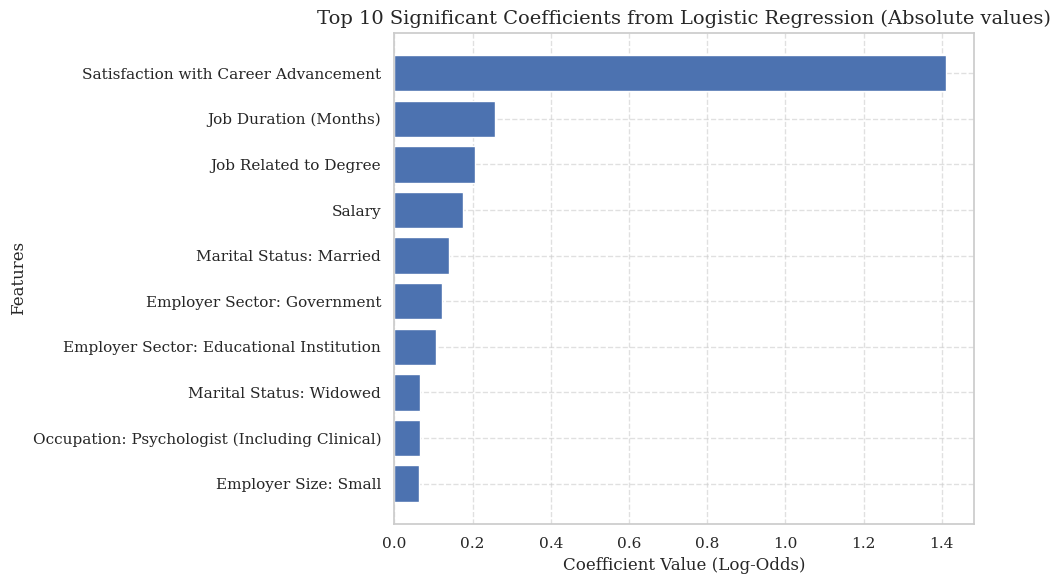

In [63]:
import matplotlib.pyplot as plt
import matplotlib

# Create a mapping of model feature names to more readable names
feature_name_mapping = {
    'satisfaction_advancement': 'Satisfaction with Career Advancement',
    'job_duration_months': 'Job Duration (Months)',
    'job_degree_relation': 'Job Related to Degree',
    'salary': 'Salary',
    'marital_status_Married': 'Marital Status: Married',
    'employer_sector_Government': 'Employer Sector: Government',
    'employer_sector_Educational Institution': 'Employer Sector: Educational Institution',
    'marital_status_Widowed': 'Marital Status: Widowed',
    'occupation_name_Psychologists, including clinical': 'Occupation: Psychologist (Including Clinical)',
    'employer_size_category_Small': 'Employer Size: Small',
}

# Extract coefficients (betas) and p-values from the fitted model (Iteration 4)
params_series = fitted_logit_iter4.params
p_values_series = fitted_logit_iter4.pvalues

# Filter for significant coefficients (p-value < 0.05)
significant_params = params_series[p_values_series < 0.05]

# Drop the constant term if it's there
if 'const' in significant_params:
    significant_params.drop('const', inplace=True)

# Select top 10 coefficients based on absolute value
top_10_params = significant_params.abs().nlargest(10).index  # Get the top 10 most significant features
top_10_significant_params = significant_params[top_10_params].sort_values(ascending=False)  # Sort by the values

# Rename the features for display purposes using the mapping
readable_names = [feature_name_mapping.get(feat, feat) for feat in top_10_significant_params.index]

# Reverse the order of the bars (for largest to smallest from top to bottom)
top_10_significant_params = top_10_significant_params[::-1]
readable_names = readable_names[::-1]

# Plotting the top 10 coefficients using a serif font
plt.figure(figsize=(10, 6))

# Use a serif font family for all text
matplotlib.rcParams['font.family'] = 'serif'

# Horizontal bar plot with readable names
plt.barh(readable_names, top_10_significant_params)
plt.xlabel('Coefficient Value (Log-Odds)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 10 Significant Coefficients from Logistic Regression (Absolute values)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


Summary of the Strongest Coefficients:

1. Top Positive Predictors:

* Satisfaction with Advancement: The more opportunities for career growth, the more likely someone is satisfied with their job.

* Job duration in months: The length someone has been in their job, is a clear indicator of overall job satisfaction. This makes sense given the learning curve often associated with being new to a job.

2. Top Negative Predictors:

* Survey Year 2021: Job satisfaction took a hit post-pandemic.

* Doctorate Degree Holders: Higher education doesn’t always equate to higher satisfaction.

It'll be helpful to inspect these further as odds ratios:

In [50]:
significant_p_values = p_values_series[p_values_series < 0.05]

In [75]:
feature_name_mapping = {
    'satisfaction_advancement': 'Satisfaction with Career Advancement',
    'job_duration_months': 'Job Duration (Months)',
    'job_degree_relation': 'Job Related to Degree',
    'salary': 'Salary',
    'children_in_household': 'Children in Household',
    'recent_degree_field_Audiology and speech pathology': 'Degree in Audiology and Speech Pathology',
    'recent_degree_field_Chemistry, except biochemistry': 'Degree in Chemistry',
    'recent_degree_field_Atmospheric sciences and meteorology': 'Degree in Atmospheric Sciences and Meteorology',
    'recent_degree_field_Public administration': 'Degree in Public Administration',
    'recent_degree_field_Physical therapy and other rehabilitation/therapeutic services': 'Degree in Physical Therapy or Rehabilitation Services',
    'recent_degree_field_Education administration': 'Degree in Education Administration',
    'recent_degree_field_Professional': 'Professional Degree',
    'recent_degree_field_Doctorate': 'Doctorate Degree',
    'recent_degree_type_Professional': 'Professional Degree Type',
    'recent_degree_type_Doctorate': 'Doctorate Degree Type',
    'marital_status_Married': 'Marital Status: Married',
    'marital_status_Widowed': 'Marital Status: Widowed',
    'employer_sector_Government': 'Employer Sector: Government',
    'employer_sector_Educational Institution': 'Employer Sector: Educational Institution',
    'ethnicity_White': 'Ethnicity: White',
    'employer_size_category_Small': 'Employer Size: Small',
    'survey_date_2021-02-01': 'Survey Date: February 2021',
    'survey_date_2017-02-01': 'Survey Date: February 2017',
    'occupation_name_Psychologists, including clinical': 'Occupation: Psychologists (Including Clinical)',
    'occupation_name_RNs, pharmacists, dieticians, therapists': 'Occupation: RNs, Pharmacists, Dieticians, Therapists',
    'occupation_name_Writers, editors, PR specialists, artists, entertainers, broadcasters': 'Occupation: Writers, Editors, PR Specialists, Artists, Broadcasters',
    'occupation_name_Sales - retail (e.g., furnishings, clothing, motor vehicles, cosmetics)': 'Occupation: Sales - Retail',
    'occupation_name_Clergy and other religious workers': 'Occupation: Clergy and Religious Workers',
    'occupation_name_Chemical engineers': 'Occupation: Chemical Engineers',
    'occupation_name_Political scientists': 'Occupation: Political Scientists',
    'occupation_name_Computer system analysts': 'Occupation: Computer System Analysts',
    'occupation_name_Computer programmers (business, scientific, process control)': 'Occupation: Computer Programmers',
    'occupation_name_Electrical, electronic, industrial, and mechanical technicians': 'Occupation: Electrical and Mechanical Technicians',
    'occupation_name_Electrical and electronics engineers': 'Occupation: Electrical and Electronics Engineers',
    'occupation_name_Other engineers, including agricultural, mining, geological': 'Occupation: Other Engineers',
    'occupation_name_OTHER teachers and instructors (private tutors, dance, flying, martial arts)': 'Occupation: Other Teachers and Instructors',
    'occupation_name_OTHER management-related occupations': 'Occupation: Management-Related Occupations',
    'occupation_name_Chemical engineers': 'Occupation: Chemical Engineers',
    'occupation_name_Psychologists, including clinical': 'Occupation: Psychologists (Including Clinical)',
    'occupation_name_RNs, pharmacists, dieticians, therapists, physician assistants, nurse practitioners': 'Occupation: Registered Nurse, Pharma, Dieticians, Therapists and Other',
    'occupation_name_Other engineers, including agricultural, mining, and geological': 'Occupation: Other engineers (agricultural, geological)',


}


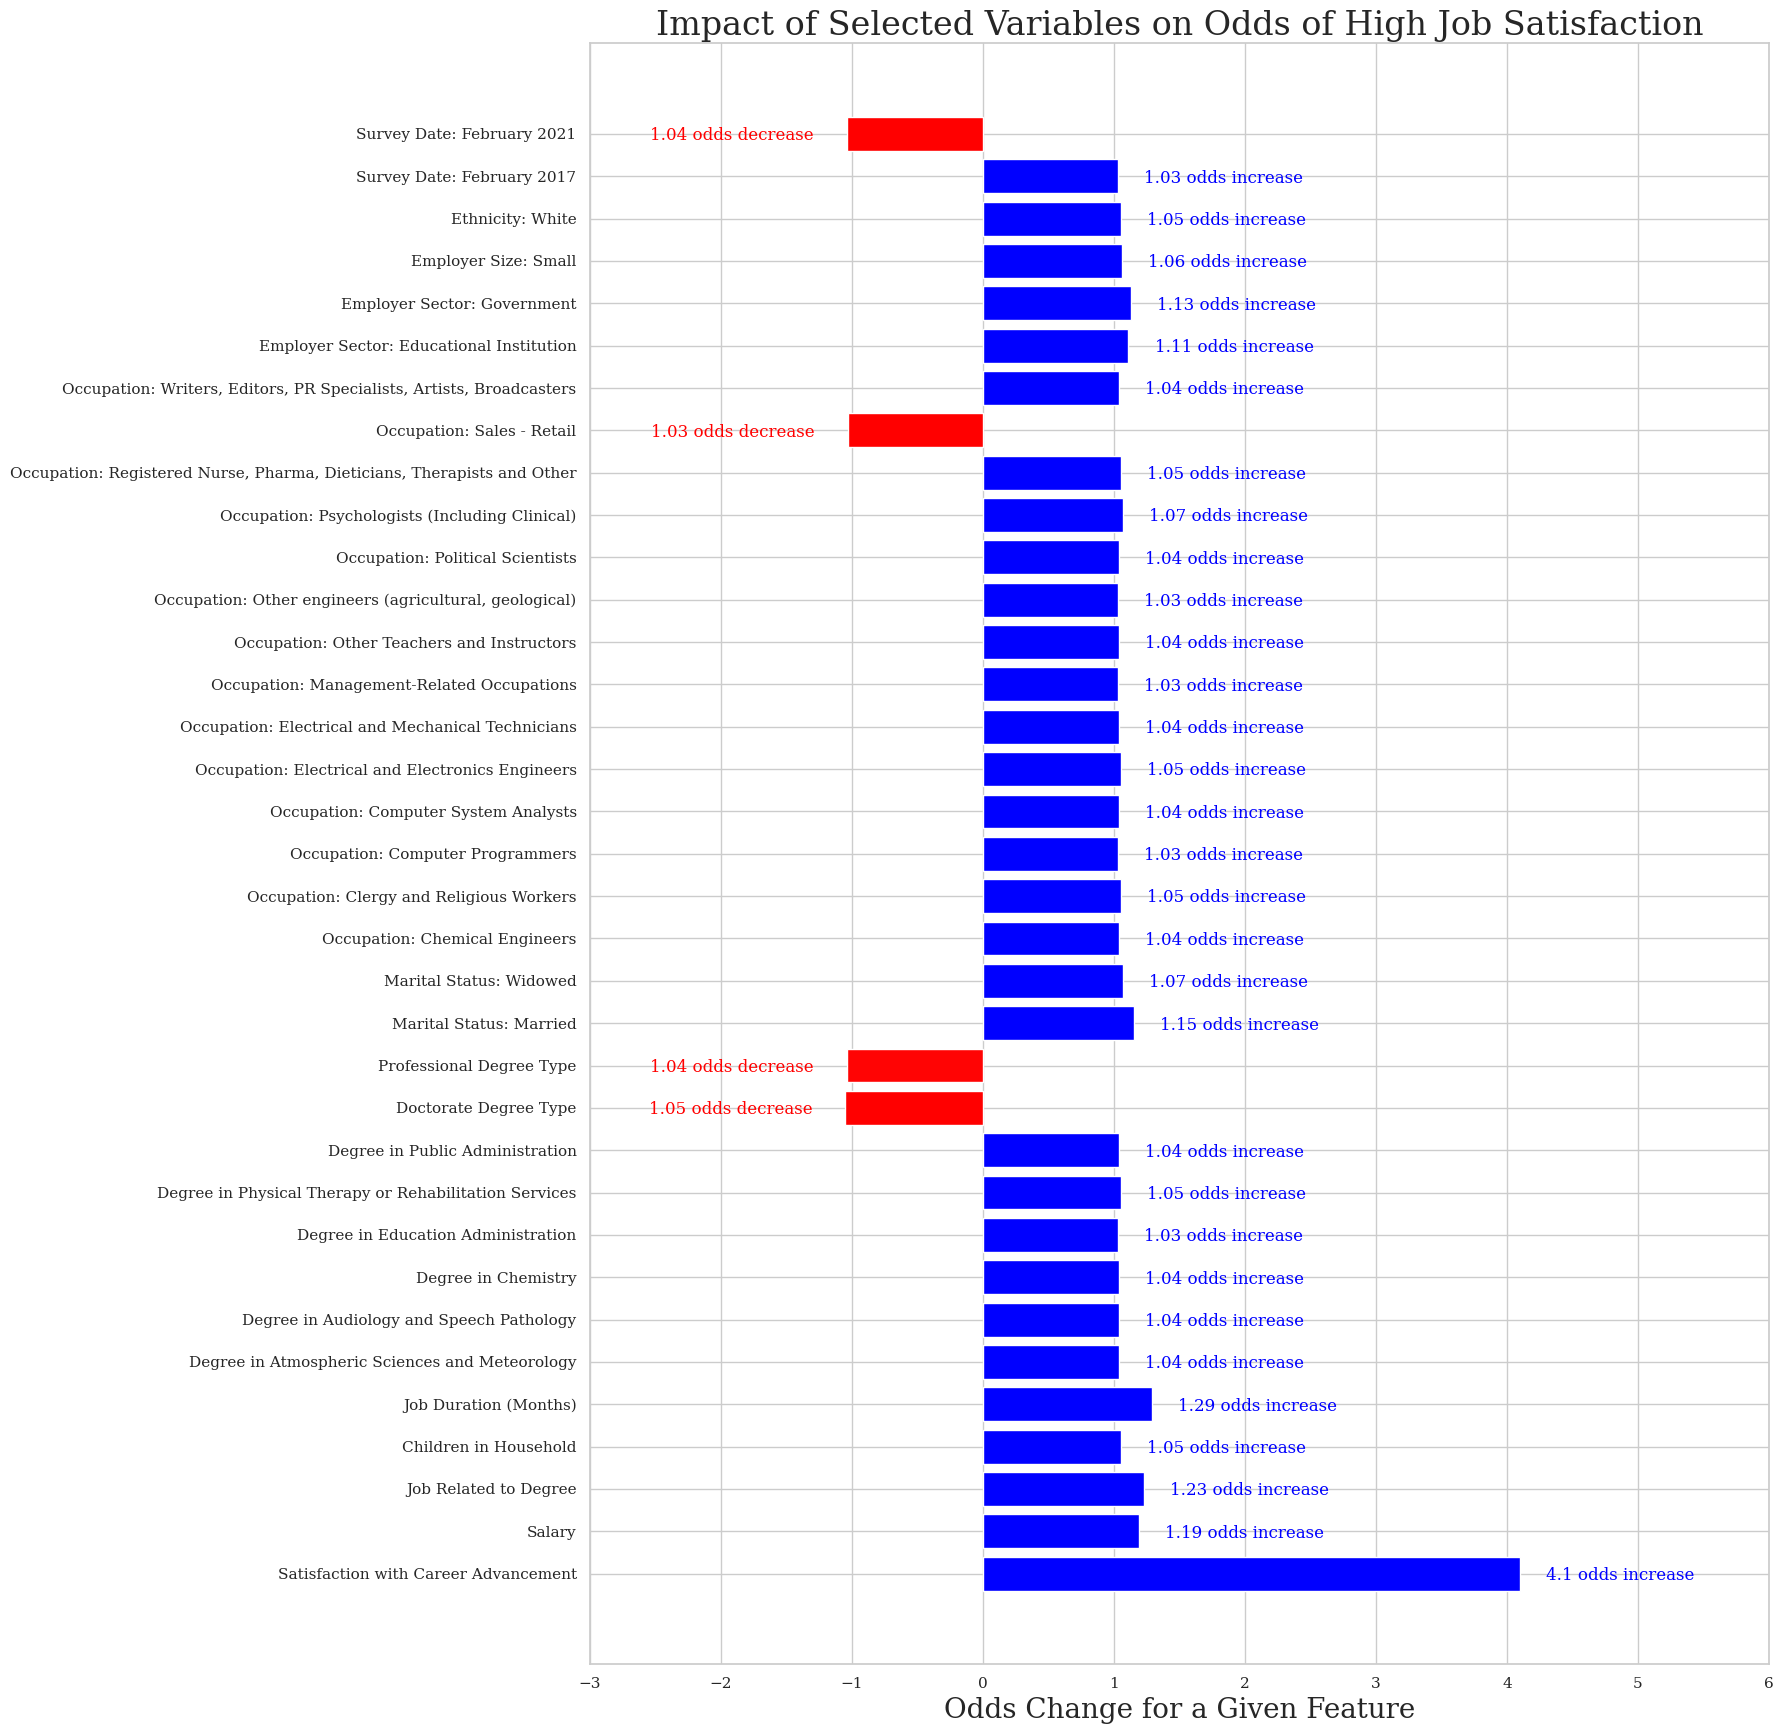

In [78]:
import matplotlib.pyplot as plt
import matplotlib

# Initialize lists
categories = []    # Labels for bars
sizes = []         # Bar heights (odds ratios)
colors = []        # Bar colors
p_values = []      # For text annotations (p-values)

p_value_color_scale = 1.5  # Scale for adjusting color based on p-value

# Iterate through significant coefficients and p-values
for index, coef_value in significant_params.items():
    variable_name = index.strip()  # Feature name (index of series)
    
    # Use the mapping to get the readable name, fallback to original if not in mapping
    readable_name = feature_name_mapping.get(variable_name, variable_name)
    
    if variable_name != 'const':   # Ignore constant term (intercept)
        odds_ratio = np.exp(coef_value)  # Convert coefficient to odds ratio

        # Filter out features with odds changes below 1.03 or above 0.97
        if odds_ratio >= 1.03 or odds_ratio <= 0.97:
            categories.append(readable_name)
            
            # Get the corresponding p-value
            p_value = round(significant_p_values[index], 2)
            p_values.append(p_value)

            # Define initial color (neutral white)
            color = [1.0, 1.0, 1.0]

            # Adjust color saturation based on p-value
            color[1] = min(p_value_color_scale * p_value, 1.0)

            # Check if odds ratio is positive or negative
            if coef_value >= 0:
                # Positive coefficient (odds increase)
                color[0] = color[1]  # Blueish color scale
                column_size = odds_ratio  # Keep the odds ratio for increase
            else:
                # Negative coefficient (odds decrease)
                color[2] = color[1]  # Redish color scale
                column_size = -1 / odds_ratio  # Convert to odds decrease

            column_size = round(column_size, 2)  # Round odds change for cleaner labels
            sizes.append(column_size)  # Add to sizes list
            colors.append(color)  # Add to colors list

# Plotting with adjustments for readability
fig, ax = plt.subplots(figsize=(18, len(categories) / 2))  # Adjust figure size dynamically based on the number of categories

# Set font to serif for the entire plot
matplotlib.rcParams['font.family'] = 'serif'

# Horizontal bar plot with readable categories
ax.barh(categories, sizes, color=colors)

# Add labels for odds change and p-values
for index, bar_size in enumerate(sizes):
    if bar_size > 0.0:
        # Odds increase label (positive)
        ax.text(bar_size + 0.2, index - 0.15, f'{bar_size} odds increase', color='blue', fontsize=12)
        
        # If p-value is >= 0.05, indicate it with text
        if p_values[index] >= 0.05:
            ax.text(-2.5, index - 0.15, f'p-value={p_values[index]}', color='blue', fontsize=12)
    else:
        # Odds decrease label (negative)
        ax.text(bar_size - 1.5, index - 0.15, f'{abs(bar_size)} odds decrease', color='red', fontsize=12)
        
        # If p-value is >= 0.05, indicate it with text
        if p_values[index] >= 0.05:
            ax.text(0.3, index - 0.15, f'p-value={p_values[index]}', color='red', fontsize=12)

# ** Adjust the x-axis limits to a smaller range **
plt.xlim(-3, 6)  # Adjusted the x-axis to match better with the range of odds ratios

# Increase font sizes for title and axes labels
plt.title("Impact of Selected Variables on Odds of High Job Satisfaction", size=24)
plt.xlabel("Odds Change for a Given Feature", size=20)
# plt.ylabel("Predictor Variables", size=20)

# Increase the size of tick labels
# ax.tick_params(axis='both', which='major', labelsize=16)

# Apply tight layout for better use of space
plt.tight_layout()

# Show the plot
plt.show()


# Note on interpretation:

### For each one standard deviation increase in the predictor variable, the odds of high job satisfaction change by the factor of the odds ratio shown.

### Here are some key takeaways:

1. Strongest Odds Increases (Blue Bars):

* Satisfaction with Advancement (4.06 odds increase): This is the most significant positive predictor of job satisfaction. If someone is satisfied with their career advancement opportunities, they are 4.06 times more likely to report high job satisfaction. Career growth clearly plays a huge role in overall satisfaction.

* Salary (1.16 odds increase): This is another strong predictor, as also supported by our in-depth EDA. Salary increases the odds of job satisfaction by 1.16 times.

* Job degree relation (1.24 odds increase): Having a job that aligns with one's educational background increases the odds of job satisfaction by 1.24 times, showing the value of working in a role that fits one’s qualifications and training.

* Female (1.08 odds increase): Being female is associated with a 1.08 times increase in the odds of job satisfaction. While this might be surprising given common assumptions, it suggests that women in the dataset may have a slightly higher likelihood of being satisfied with their jobs.

* Job Duration is also a strong indicator of job satisfaction, suggesting the importance of job tenure in determining job satisfaction.

2. Strongest Odds Decreases (Red Bars):

* Doctorate Degree (1.05 odds decrease): Individuals with a doctorate are 1.05 times less likely to report job satisfaction, which might tie into the importance of better job matching for individuals in highly specialised fields.

* Individuals surveyed post pandemic: Individuals surveyed during 2021 were 1.04 x less likely to report high job satisfaction, perhaps an indicator of patterns we saw relating to the 'Great Resignation'

# Honing in on the top 20 positive predictors of high job satisfaction

In [81]:
feature_name_mapping = {
    'satisfaction_advancement': 'Satisfaction with Career Advancement',
    'job_duration_months': 'Job Duration (Months)',
    'job_degree_relation': 'Job Related to Degree',
    'salary': 'Salary',
    'marital_status_Married': 'Marital Status: Married',
    'employer_sector_Government': 'Employer Sector: Government',
    'employer_sector_Educational Institution': 'Employer Sector: Educational Institution',
    'marital_status_Widowed': 'Marital Status: Widowed',
    'occupation_name_Psychologists, including clinical': 'Occupation: Psychologists (Including Clinical)',
    'employer_size_category_Small': 'Employer Size: Small',
    'occupation_name_Clergy and other religious workers': 'Occupation: Clergy and Religious Workers',
    'ethnicity_White': 'Ethnicity: White',
    'recent_degree_field_Physical therapy and other rehabilitation/therapeutic services': 'Degree in Physical Therapy or Rehabilitation Services',
    'occupation_name_RNs, pharmacists, dieticians, therapists, physician assistants, nurse practitioners': 'Occupation: RNs, Pharmacists, Therapists, etc.',
    'occupation_name_Electrical and electronics engineers': 'Occupation: Electrical and Electronics Engineers',
    'children_in_household': 'Children in Household',
    'recent_degree_field_Audiology and speech pathology': 'Degree in Audiology and Speech Pathology',
    'occupation_name_Computer system analysts': 'Occupation: Computer System Analysts',
    'recent_degree_field_Atmospheric sciences and meteorology': 'Degree in Atmospheric Sciences and Meteorology',
    'occupation_name_Electrical, electronic, industrial, and mechanical technicians': 'Occupation: Electrical, Industrial, and Mechanical Technicians'
}


/var/folders/d8/f47z80nj3835j2cjhqsrtc6r0000gn/T/ipykernel_83058/3094394112.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Odds Ratio', y='Feature', data=plot_data, palette='Blues_d')


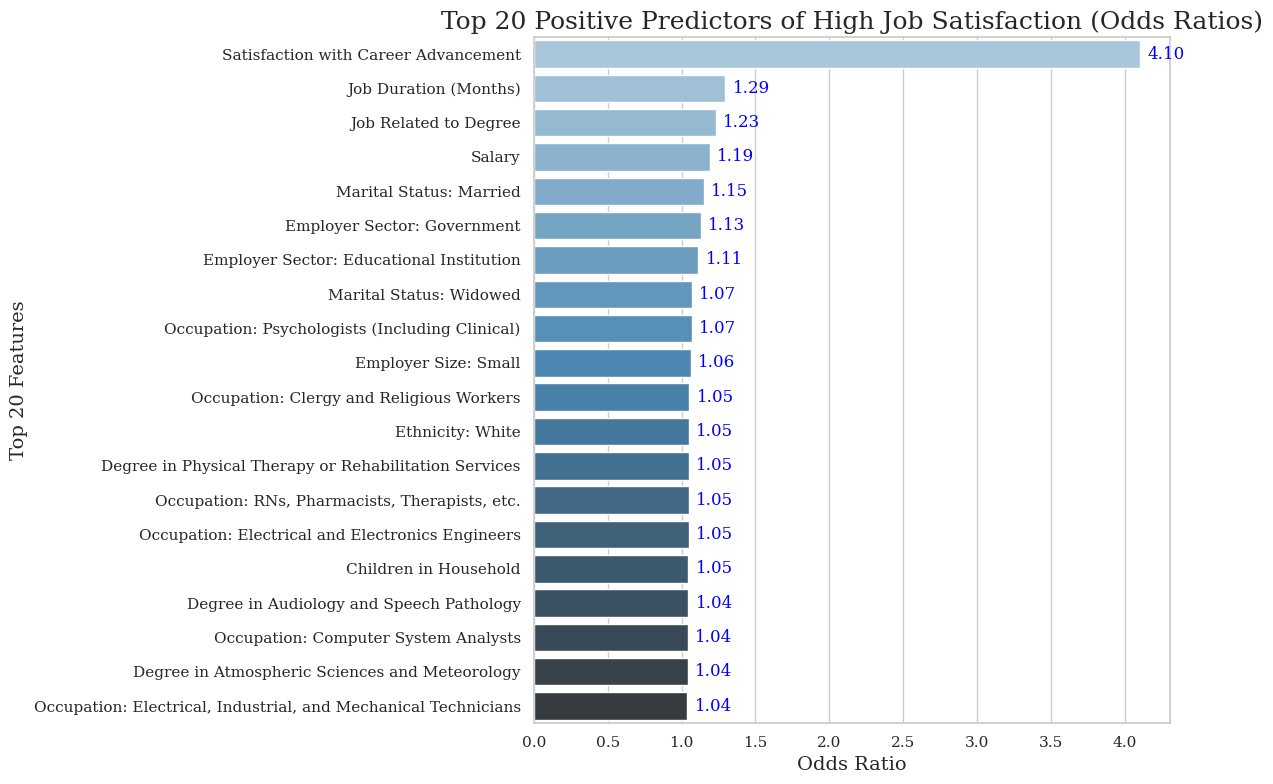

In [82]:
# Automatically select the top 20 positive coefficients from significant_params
top_20_features = significant_params.sort_values(ascending=False).head(20)

# Convert coefficients to odds ratios
top_20_odds_ratios = np.exp(top_20_features)

# Map feature names to more readable names based on the image
top_20_features_readable = [feature_name_mapping.get(feat, feat) for feat in top_20_features.index]

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Feature': top_20_features_readable,  # Use readable feature names
    'Odds Ratio': top_20_odds_ratios      # Corresponding odds ratios
})

# Sort the features by odds ratio for cleaner plotting, reverse to have the highest odds ratio on top
plot_data = plot_data.sort_values(by='Odds Ratio', ascending=False)

# Set up the figure size and plot
plt.figure(figsize=(12, 8))

# Create a horizontal barplot using seaborn, reverse the order of the y-axis
sns.barplot(x='Odds Ratio', y='Feature', data=plot_data, palette='Blues_d')

# Add labels to each bar with the odds ratio value
for index, value in enumerate(plot_data['Odds Ratio']):
    plt.text(value + 0.05, index, f'{value:.2f}', color='blue', va="center")

# Customize the plot with titles and labels
plt.title("Top 20 Positive Predictors of High Job Satisfaction (Odds Ratios)", fontsize=18)
plt.xlabel("Odds Ratio", fontsize=14)
plt.ylabel("Top 20 Features", fontsize=14)

# Tighten the layout for better presentation
plt.tight_layout()

# Show the plot
plt.show()


# Summary

The plot above lays key features of interest more clearly, paritcularly for jobseekers as well as policymakers interested in understanding predictors of satisfaction in the labour market.

The plot visualizes the top 20 positive predictors of high job satisfaction, expressed in terms of odds ratios. Each odds ratio shows how a one standard deviation increase in the respective feature results in an increase in the likelihood (odds) of a graduate reporting high job satisfaction.

### Key Insights for Graduate Jobseekers:

Satisfaction with Advancement (OR = 4.06):

* Graduates who feel that their job provides advancement opportunities have significantly higher job satisfaction.
* Actionable Insight: Focus on roles with clear career progression to increase job satisfaction.

Job Duration (OR = 1.32):

* The longer a graduate stays in their job (in months), the more likely they are to report being satisfied with their job.
* Actionable Insight: Stability and persistence in a job, even for the first few months, can lead to greater satisfaction.

Job-Degree Relation (OR = 1.24):

* Graduates working in jobs closely related to their degree field are more likely to report high satisfaction.
* Actionable Insight: Seek roles where your degree directly applies to your work to increase job satisfaction.

Salary (OR = 1.16):

* Higher salaries are positively associated with higher job satisfaction, but not as strongly as other factors like advancement.
* Actionable Insight: While salary is important, it should be considered alongside other factors like career growth.

Marital Status – Married (OR = 1.15):

* Respondents who are married tend to report higher job satisfaction.
* Actionable Insight: Personal circumstances, like stability in home life, may be an indicator of job satisfaction.

Employer Sector (Government OR = 1.11, Educational Institutions OR = 1.09):

* Working in government or educational institutions is associated with higher job satisfaction.
* Actionable Insight: Individuals may consider the tradeoffs between roles in the public or educational sectors compared to slaary and career advancement benefits in the private sector.

## Key Insights for Policymakers (Labour Market):

Employer Size (Small OR = 1.06):

* Graduates working in smaller companies tend to report higher job satisfaction.
* Policy Insight: Promote opportunities in SME orgs, as they may provide more personalised career growth and job satisfaction - as well as wider contributions to the economy.

Ethnicity (White OR = 1.05):

* White graduates report slightly higher job satisfaction, highlighting a need to focus on equity and addressing potential gaps for other ethnic groups.
* Policy Insight: Investigate and address factors contributing to disparities in job satisfaction across ethnic groups.

Specialized Occupations (Psychologists, Engineers, Teachers):

* Occupations in specialized fields (psychologists, engineers, teachers) show slightly higher satisfaction levels.
* Policy Insight: Invest in career development and support for specialized professionals to maintain job satisfaction and reduce turnover.

Degree Relevance and Field:

* Graduates in fields such as physical therapy, atmospheric sciences, and rehabilitation report higher job satisfaction when working in related fields.
* Policy Insight: Support programmes and higher education intitution to align graduates' education with their job opportunities to boost satisfaction.

# 10. Model Performance

## First, let's evaluate the train and test accuracies calculated through our model iterations:

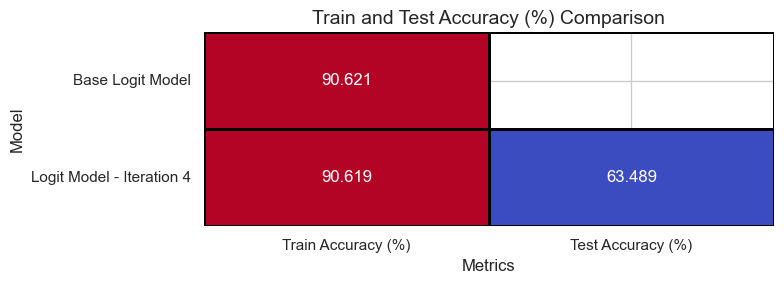

In [53]:
accuracy_data = {
    'Train Accuracy (%)': [pct_accuracy_train * 100, pct_accuracy_train_iter4 * 100],
    'Test Accuracy (%)': [np.nan, pct_accuracy_test_iter4 * 100]  # Only Iteration 4 has test accuracy
}

accuracy_df = pd.DataFrame(accuracy_data, index=['Base Logit Model', 'Logit Model - Iteration 4'])

# Create a mask for the missing (NaN) values
mask = accuracy_df.isna()

# Plot a heatmap with a mask to hide NaN values
plt.figure(figsize=(8, 3))
sns.heatmap(accuracy_df, annot=True, fmt='.3f', cmap="coolwarm", cbar=False, linewidths=1, linecolor='black', mask=mask)

# Set labels and title
plt.title("Train and Test Accuracy (%) Comparison", fontsize=14)
plt.ylabel("Model", fontsize=12)
plt.xlabel("Metrics", fontsize=12)

plt.tight_layout()
plt.show()


As we saw earlier, we saw a marginal improvement in our train accuracy after carrying our backwards selection on our logistic regression. However, when we evaluate performance on unseen data, we can see clear overfitting of our model to the training data - our test accuracy was much lower at 63%.

Saving the train and test accuracies for later use:

In [56]:
# Save the train and test accuracies
joblib.dump(pct_accuracy_train_iter4, '../models/pct_accuracy_train_iter4.pkl')
joblib.dump(pct_accuracy_test_iter4, '../models/pct_accuracy_test_iter4.pkl')

['../models/pct_accuracy_test_iter4.pkl']

## Evaluating our model beyond accuracy

Whilst the above evaluation metric is helpful, this doesn't necessarily provide the full picture of our model's performance. For example, we know there is a large class imbalance with over 90% of respondents belonging to the 'high jobsatisfaction' target variable category. 

We can make a start with understanding this using scikit-learn - however, we will expand on this further in our next notebook focuisng on more advanced modelling:

## Confusion Matrix

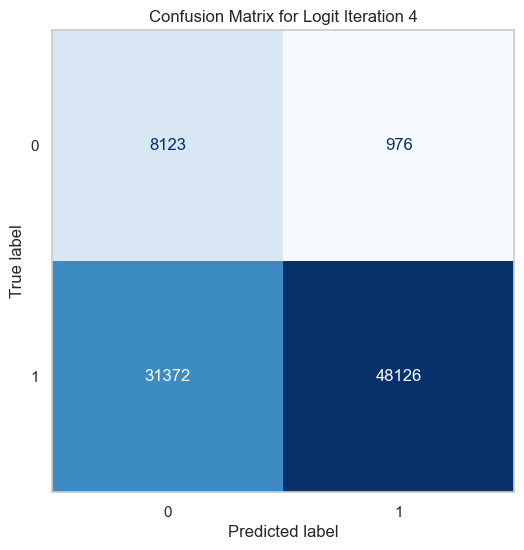

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predicted binary outcomes based on a threshold of 0.5
y_test_pred = (fitted_logit_iter4.predict(X_test_final_const_aligned) >= 0.5).astype(int)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title('Confusion Matrix for Logit Iteration 4')
plt.grid(False)
plt.show()


# Explanation

1. True Negatives (TN):

* 8,123 instances where the actual class was Not High Satisfaction (0), and the model correctly predicted Not High Satisfaction (0).

* These are correct predictions where the model identified people as having low job satisfaction.

2. False Positive (FP):

* 976 instances where the actual class was Not High Satisfaction (0), but the model incorrectly predicted High Satisfaction (1).
* Overall numbers of false positives is pretty low.

3. True Positive (TP) :

* 48,126 instances where the actual class was High Satisfaction (1), and the model correctly predicted High Satisfaction (1).

4. False Negatives (FN):

* 31,372 instances where the actual class was High Satisfaction (1), but the model incorrectly predicted Not High Satisfaction (0).

# Overall, this means that:

* The model is good at identifying those with high job satisfaction (48,126 True Positives).
* It also correctly identifies those without high satisfaction in 8,123 True Negative cases.

# However:

* The number of False Negatives indicates that the model misses a significant portion of individuals who are actually highly satisfied. 
* Precision (for class 1 - high satisfaction)...will be high since the model has a low number of False Positives compared to True Positives.
* Recall (for class 1 - high satisfaction)...will likely be lower due to the high number of False Negatives—it misses many people who actually have high job satisfaction.


# 11. Conclusion and next steps

## (a) Actionable insights:

### Overall, we learnt about key actionable insights for our stakeholders, including jobseekers and labour market policymakers. These linked to:

* **Satisfaction with career advancement as the biggest predictor of overall job satisfaction.**

* Career growth is a huge factor for employees, and influences their job satisfaction. Holding all else constant, it continues to be a signifciant predictor suggesting salary alone doesn't suffice.

### Other learnings included:

**Employer Size**

* Finding: Graduates in smaller companies report higher job satisfaction.
* Policy Insight: Promote opportunities in SMEs, as they may offer more personalized career growth and contribute positively to job satisfaction and the economy.

**Ethnicity**

* Finding: White graduates report slightly higher job satisfaction.
* Policy Insight: Address disparities in job satisfaction across ethnic groups by investigating and addressing contributing factors.

**Degree Relevance and Field:**

* Finding: Graduates working in fields related to their degrees report higher job satisfaction.
* Policy Insight: Align higher education programs with job opportunities to boost job satisfaction for graduates.

## (b) Next steps

### Acting on findings from the confusion matrix:

* High Precision for Positive Class: This indicates that the model is reliable in predicting high satisfaction, but we need to ensure it also identifies all true positives. Improve recall for high satisfaction by potentially adjusting the classification threshold or using techniques like oversampling the minority class.

* Low Recall for Positive Class: Address the high number of false negatives by exploring other models or techniques that might capture more positives, such as ensemble methods or different threshold settings.

### Addressing overfitting and exploring Decision Tree Model:

The findings from the baseline logistic regression model reveal strong precision in predicting high job satisfaction, but the low recall for the positive class suggests that we may be missing a significant number of true positives. This imbalance can be addressed through further model refinement or by exploring other modeling techniques that may better capture the complex patterns in the data.

To address overfitting, particularly given the high precision but low recall for the positive class, we will now explore a Decision Tree model. Decision Trees offer several advantages:

* Non-linear relationships: Unlike logistic regression, which assumes a linear relationship between features and the target, Decision Trees can capture non-linear relationships in the data, which may help in identifying additional true positives.

* Feature importance: Decision Trees also provide a natural way to assess the importance of different features, helping us better understand which factors contribute most to job satisfaction.

We will begin with a coarse analysis of the Decision Tree, tuning parameters such as the maximum depth, minimum samples per leaf, and maximum number of features to avoid overfitting while improving the model's ability to generalize to new data. Additionally, we will apply cross-validation to ensure that the model performs well across different subsets of the data.

**By comparing the results of the Decision Tree with the baseline logistic regression, we aim to develop a more balanced model that achieves both high precision and recall.**

But first, there are a couple of preprocessing gaps we can address before springboarding into more advanced modelling ([Proceed to Preparation for Advanced Modelling Notebook](../notebooks/05%20Preparing%20for%20advanced%20modelling.ipynb))

